In [2]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TactileMaterialDataset(Dataset):
    def __init__(self, file_path, material = None):

        with h5py.File(file_path, 'r') as dataset:
            raw_samples = dataset['samples'][:] / 154.  # Normalize
            materials = [i.decode() for i in dataset['materials'][:]]  # Decode material names
        
        if material is not None:
            self.samples = raw_samples[material, :, :, :, :].reshape(1, 100, 16, 1000).reshape(-1, 1000)
            materials = np.array([1])

        else:
            self.samples = raw_samples.reshape(36, 100, 16, 1000).reshape(-1, 1000)

        # Apply FFT along the last axis and separate real & imaginary parts
        fft_transformed = np.fft.rfft(self.samples, axis=1)
        self.samples = np.stack((fft_transformed.real, fft_transformed.imag), axis=0) 
        self.samples = self.samples.reshape(-1, 1002)

        self.samples = torch.tensor(self.samples, dtype=torch.float32) 
        self.labels = torch.tensor(np.repeat(range(len(materials)), 100*16)) 
            
        # np.fft.fft
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

In [48]:
import os
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.patches import Rectangle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# ========== Your imports from the provided code ==========
# e.g., from your_module import (
#     TactileMaterialDataset, Ff, Fm, device,
#     information_bottleneck_loss, adaptive_beta, ClassConditionalGMM,
#     SwapPermutationAllInOneBlock, subnet_fc
# )

# If you have them in the same file, just ensure they're defined above this script.

# ========== Visualization Functions ==========

def plot_confusion_matrix(true_labels, predicted_labels, n_classes, output_dir='.', filename='confusion_matrix.png'):
    """
    Plots a normalized confusion matrix given true and predicted labels.
    Saves the figure as 'confusion_matrix.png' by default.
    """
    # Compute normalized confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=range(n_classes), normalize='true')

    # Set global font sizes (optional)
    plt.rcParams.update({
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
    })

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(conf_matrix, cmap='gray_r', annot=True, fmt='.2f',
                     square=True, cbar=True, linewidths=0,
                     xticklabels=range(n_classes),
                     yticklabels=range(n_classes))

    # Add a rectangle around the matrix for a thicker border
    num_rows, num_cols = conf_matrix.shape
    rect = Rectangle((0, 0), num_cols, num_rows, fill=False, edgecolor='black', linewidth=2.5)
    ax.add_patch(rect)

    # Set axis labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()

    # Save the plot
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, filename))
    plt.close()


def plot_class_wise_accuracy(true_labels, predicted_labels, n_classes, output_dir='.', filename='per_class_accuracy.png'):
    """
    Plots per-class accuracy as a bar chart, sorted from highest to lowest.
    Saves the figure as 'per_class_accuracy.png' by default.
    """
    # Compute accuracy for each class
    class_accuracies = []
    for class_idx in range(n_classes):
        mask = (true_labels == class_idx)
        if mask.sum() == 0:
            # If no samples of this class, set accuracy to 0 or handle differently
            class_accuracies.append(0.0)
        else:
            correct = (predicted_labels[mask] == class_idx).sum()
            class_accuracies.append(correct / mask.sum())

    # Convert to percentages
    class_accuracies = np.array(class_accuracies) * 100
    overall_accuracy = accuracy_score(true_labels, predicted_labels) * 100

    # Sort by accuracy
    sorted_indices = np.argsort(class_accuracies)[::-1]
    sorted_accuracies = class_accuracies[sorted_indices]

    # Set font sizes (optional)
    plt.rcParams.update({
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 14
    })

    plt.figure(figsize=(12, 5))
    x_positions = np.arange(len(sorted_accuracies))

    # Plot bar chart
    plt.bar(x_positions, sorted_accuracies, color='blue', label='Accuracy')
    plt.xticks(x_positions, sorted_indices, rotation=90)
    plt.xlabel('Material/Class ID (sorted)')
    plt.ylabel('Accuracy [%]')

    # Horizontal line at mean accuracy
    mean_acc = np.mean(sorted_accuracies)
    plt.axhline(y=mean_acc, color='gray', linestyle='--', label='Mean Accuracy')

    plt.title(f'Per-Class Accuracy (Overall: {overall_accuracy:.2f}%)')
    plt.legend()

    # Add thicker border
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)

    # Save the plot
    plt.tight_layout()
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, filename))
    plt.close()

In [96]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm
import torch
from tqdm import tqdm
import torch.nn.functional as F


def subnet_fc(dims_in, dims_out, hidden_layer_size=512):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_size), 
                         nn.ReLU(),
                         nn.Linear(hidden_layer_size,  dims_out),
                         )


class ClassConditionalGMM(nn.Module):
    def __init__(self, n_classes, latent_dim):
        super(ClassConditionalGMM, self).__init__() 
        # init mu to be the identity matrix
        init_scale = 1.0 / np.sqrt(2 * (latent_dim // n_classes))
        self.mu = nn.Parameter(torch.zeros(1, n_classes, latent_dim))
        for k in range(latent_dim // n_classes):
            # self.mu.data[0, :, n_classes * k: n_classes * (k + 1)] = init_scale * torch.eye(n_classes)
            self.mu = nn.Parameter(0.1 * torch.randn(1, n_classes, latent_dim))
        self.logvar = torch.full((n_classes, latent_dim), 1.0)  # Fixed variance


    def forward(self, z):
        # Compute log-probabilities for each class
        z_expanded = z.unsqueeze(1)
        mu = self.mu.unsqueeze(0)
        logvar = self.logvar.to(device).unsqueeze(0)
        log_p = -0.5 * (logvar + (z_expanded - mu)**2 / logvar.exp()) # the core log gaussian density
        return log_p.sum(dim=-1).log_softmax(dim=-1)  # normalize to get valid probabilities

def cluster_distances(z, mu):
    z_i_z_i = torch.sum(z**2, dim=1, keepdim=True)  # batchsize x 1
    mu_j_mu_j = torch.sum(mu**2, dim=2)             # 1 x n_classes
    z_i_mu_j = torch.mm(z, mu.squeeze().t())        # batchsize x n_classes

    return -2 * z_i_mu_j + z_i_z_i + mu_j_mu_j


def information_bottleneck_loss(x, y, model, gmm, beta=1.0):

    z, log_detJ = model(x)  
    # z_noisy = z + 0.01 * torch.randn_like(z).to(device)
    dist = cluster_distances(z, gmm.mu)  # shape (batch_size, n_classes)

    nll_joint = -torch.logsumexp(-0.5 * dist, dim=1) - log_detJ
    L_gen_batch = nll_joint.mean() / z.shape[1]

    logits = -0.5 * dist  # (batch_size, n_classes)
    L_cls_batch = F.cross_entropy(logits, y.to(z.device))

    L_gen = L_gen_batch.mean()
    L_cls = L_cls_batch.mean()
    L_total = L_gen + beta * L_cls

    return L_total, dist, L_gen, L_cls


def adaptive_beta(epoch, total_epochs, min_beta=0.25, max_beta=3.0, schedule_type="linear"):
    if schedule_type == "linear":
        return min_beta + (max_beta - min_beta) * (epoch / total_epochs)
    elif schedule_type == "exponential":
        # Exponential schedule: min_beta * (max_beta/min_beta)^(epoch/total_epochs)
        return min_beta * ((max_beta / min_beta) ** (epoch / total_epochs))
    else:
        raise ValueError("schedule_type must be either 'linear' or 'exponential'")


class SwapPermutationAllInOneBlock(Fm.AllInOneBlock):
    def __init__(self, dims_in, dims_c=[], subnet_constructor=None, **kwargs):
        if subnet_constructor is None:
            raise ValueError("A subnet_constructor must be provided.")
        super(SwapPermutationAllInOneBlock, self).__init__(dims_in, dims_c, subnet_constructor, **kwargs)

    def _permute(self, x, rev=False): #swap permute
        mid = x.size(1) // 2
        swapped = torch.cat([x[:, mid:], x[:, :mid]], dim=1)
        return swapped, 0


    



In [79]:
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import copy

def train_inn_gmm(
    dataset_path,          
    n_coupling_blocks=2,
    epochs=20,
    max_beta=0.75,
    min_beta=0.25,
    lr=0.001,
    lr_mu=0.0001,
    weight_decay=1e-5,
    train_split=0.8,
    n_classes=36,
    hidden_layer_size=512,
    patience=5,
    schedule_type="linear",
    swap_permute=True,
    output_dir='.',
):

    
    batch_size = 16
    N_DIM = 1002

    full_dataset = TactileMaterialDataset(dataset_path)
    train_size = int(train_split * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_subset, val_subset = random_split(full_dataset, [train_size, val_size])
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)
    
    torch.cuda.empty_cache()  # optional

    inn = Ff.SequenceINN(N_DIM).to(device)
    for k in range(n_coupling_blocks):
        if swap_permute==True:
            inn.append(SwapPermutationAllInOneBlock, 
                    subnet_constructor=lambda dims_in, dims_out: subnet_fc(dims_in, dims_out, hidden_layer_size=hidden_layer_size))
        else:
            inn.append(Fm.AllInOneBlock, 
                    subnet_constructor=lambda dims_in, dims_out: subnet_fc(dims_in, dims_out, hidden_layer_size=hidden_layer_size))


    gmm = ClassConditionalGMM(n_classes=n_classes, latent_dim=N_DIM).to(device)



    optimizer = torch.optim.Adam([
        {'params': inn.parameters(), 'lr': lr, 'weight_decay': weight_decay},
        {'params': gmm.mu, 'lr': lr_mu, 'weight_decay': 0.0}
    ])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    inn.to(device)
    gmm.to(device)


    train_losses   = []
    val_losses     = []
    val_accs       = []
    val_accs_top5  = []
    
    # Early-stopping variables
    best_val_acc = 0
    patience_counter = 0
    best_inn_state = copy.deepcopy(inn.state_dict())
    best_gmm_state = copy.deepcopy(gmm.state_dict())

    # Training Loop

    print("Starting training loop...")
    for epoch in range(epochs):
        beta = adaptive_beta(epoch, epochs, min_beta=min_beta, max_beta=max_beta, schedule_type=schedule_type)
        
        inn.train()
        train_loss_epoch = 0.0
        
        for x_batch, c_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            x_batch = x_batch.to(device)
            c_batch = c_batch.to(device)
            
            optimizer.zero_grad()
            
            loss, _, _, _ = information_bottleneck_loss(x_batch, c_batch, inn, gmm, beta)
            train_loss_epoch += loss.item()
            
            loss.backward()
            optimizer.step()
        
        train_loss_epoch /= len(train_loader)
        train_losses.append(train_loss_epoch)
        
        # Val
        inn.eval()
        val_loss_epoch = 0.0
        correct_top1 = 0
        correct_top5 = 0
        total_samples = 0
        
        with torch.no_grad():
            for x_batch, c_batch in val_loader:
                x_batch = x_batch.to(device)
                c_batch = c_batch.to(device)
                
                loss, dist, L_gen, L_cls = information_bottleneck_loss(x_batch, c_batch, inn, gmm, beta)
                val_loss_epoch += loss.item()
                
                y_ = -0.5 * dist
                preds = y_.argmax(dim=1)
                correct_top1 += (preds == c_batch).sum().item()
                
                y_top_k = y_.topk(k=5, dim=1)[1]
                correct_top5 += y_top_k.eq(c_batch.unsqueeze(1)).sum().item()
                
                total_samples += c_batch.size(0)
        
        val_loss_epoch /= len(val_loader)
        val_losses.append(val_loss_epoch)
        
        val_acc = correct_top1 / total_samples
        val_accs.append(val_acc)
        
        val_acc_5 = correct_top5 / total_samples
        val_accs_top5.append(val_acc_5)
        
        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Train Loss: {train_loss_epoch:.4f}, "
              f"Val Loss: {val_loss_epoch:.4f}, "
              f"Val Acc (Top-1): {val_acc:.4f}, "
              f"Val Acc (Top-5): {val_acc_5:.4f}, "
              f"L_gen mean: {L_gen.mean():.4f}, "
              f"L_cls mean: {L_cls.mean():.4f}, "
              f"beta: {beta:.4f}")
        
        # Early Stopping Check

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            
            best_inn_state = copy.deepcopy(inn.state_dict())
            best_gmm_state = copy.deepcopy(gmm.state_dict())
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break
    
    inn.load_state_dict(best_inn_state)
    gmm.load_state_dict(best_gmm_state)

    print("Training complete, Best Accuracy: ", best_val_acc)
    
    logs = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'val_accs_top5': val_accs_top5,
    }
    


    # ----- Final Evaluation for Visualization -----
    # We'll collect predictions and labels on the entire val_loader
    all_preds = []
    all_labels = []

    inn.eval()
    with torch.no_grad():
        for x_batch, c_batch in val_loader:
            x_batch = x_batch.to(device)
            c_batch = c_batch.to(device)

            _, dist, _, _ = information_bottleneck_loss(x_batch, c_batch, inn, gmm, beta=1.0)
            y_ = -0.5 * dist
            preds = y_.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(c_batch.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # ========== Create Plots ==========
    os.makedirs(output_dir, exist_ok=True)
    plot_confusion_matrix(all_labels, all_preds, n_classes=n_classes,
                          output_dir=output_dir, filename='confusion_matrix.png')
    plot_class_wise_accuracy(all_labels, all_preds, n_classes=n_classes,
                             output_dir=output_dir, filename='per_class_accuracy.png')

    # Optionally, save logs, predictions, etc.
    with open(os.path.join(output_dir, 'logs.pkl'), 'wb') as f:
        pickle.dump(logs, f)

    # Return model, logs, and final predictions
    return inn, gmm, logs, (all_preds, all_labels) 


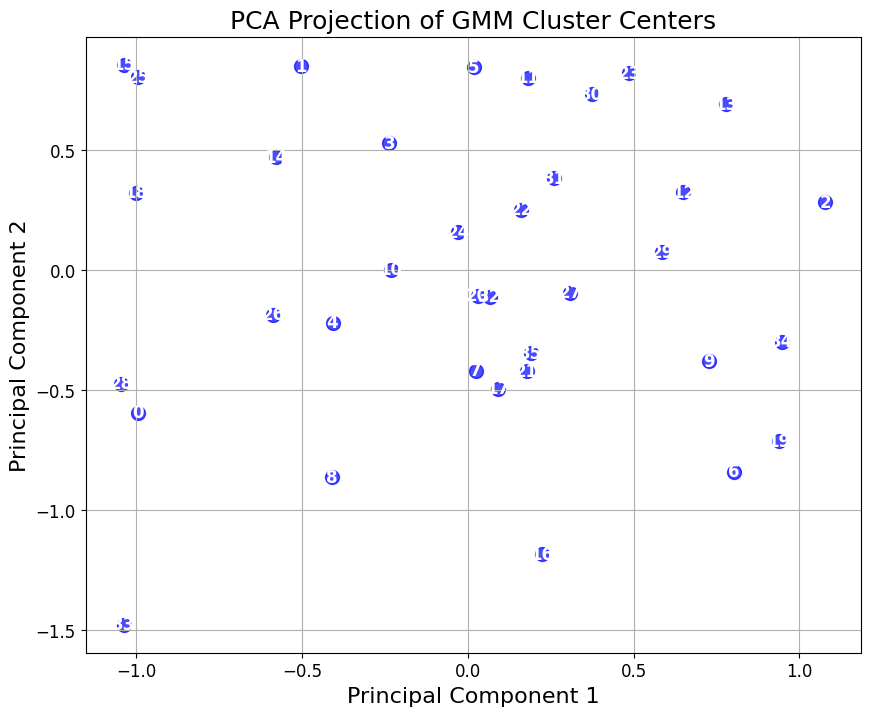

In [97]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Instantiate a new GMM with 36 classes and latent dimension 1002.
gmm_test = ClassConditionalGMM(n_classes=36, latent_dim=1002).to(device)

# Extract the mu parameter. Its shape is (1, n_classes, latent_dim)
# We remove the batch dimension to get a shape (n_classes, latent_dim).
mu = gmm_test.mu.detach().cpu().numpy().squeeze(0)  # shape: (36, 1002)

# Use PCA to reduce the latent dimension to 2 for visualization
pca = PCA(n_components=2)
mu_pca = pca.fit_transform(mu)

# Plot the cluster centers in 2D
plt.figure(figsize=(10, 8))
plt.scatter(mu_pca[:, 0], mu_pca[:, 1], s=100, c='blue', alpha=0.7)

# Annotate each cluster center with its cluster index
for idx, (x, y) in enumerate(mu_pca):
    plt.text(x, y, str(idx), fontsize=12, ha='center', va='center', color='white', weight='bold')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of GMM Cluster Centers")
plt.grid(True)
plt.show()


In [98]:
import os
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.patches import Rectangle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# -------------------------------
# Setup: Dataset, Model, and Utils
# -------------------------------

# Make sure these are imported or defined:
# - TactileMaterialDataset
# - Ff (FrEIA.framework)
# - Fm (FrEIA.modules)
# - device (e.g., torch.device("cuda") or "cpu")
# - information_bottleneck_loss, adaptive_beta, cluster_distances
# - ClassConditionalGMM, subnet_fc, SwapPermutationAllInOneBlock

# Hyperparameters
dataset_path      = "data/raw/tactmat.h5"
n_coupling_blocks = 4
epochs            = 10
max_beta          = 3
min_beta          = 3
lr                = 0.001
lr_mu             = 0.001
weight_decay      = 1e-4
train_split       = 0.8
n_classes         = 36
hidden_layer_size = 512
patience          = 10
schedule_type     = "linear"
swap_permute      = False
output_dir        = "output_inn"
batch_size        = 16
N_DIM             = 1002


# Create dataset and split into train and validation subsets
full_dataset = TactileMaterialDataset(dataset_path)
train_size = int(train_split * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)

torch.cuda.empty_cache()  # optional

# Build the INN model
inn = Ff.SequenceINN(N_DIM).to(device)
for k in range(n_coupling_blocks):
    if swap_permute:
        inn.append(
            SwapPermutationAllInOneBlock, 
            subnet_constructor=lambda dims_in, dims_out: subnet_fc(dims_in, dims_out, hidden_layer_size=hidden_layer_size)
        )
    else:
        inn.append(
            Fm.AllInOneBlock, 
            subnet_constructor=lambda dims_in, dims_out: subnet_fc(dims_in, dims_out, hidden_layer_size=hidden_layer_size)
        )

# Build the GMM
gmm = ClassConditionalGMM(n_classes=n_classes, latent_dim=N_DIM).to(device)

# Optimizer and Scheduler
optimizer = optim.Adam([
    {'params': inn.parameters(), 'lr': lr, 'weight_decay': weight_decay},
    {'params': gmm.mu, 'lr': lr_mu, 'weight_decay': 0.0}
])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

inn.to(device)
gmm.to(device)

# Logging lists and early stopping setup
train_losses    = []
val_losses      = []
val_accs        = []
val_accs_top5   = []
best_val_acc    = 0.0
patience_counter= 0
best_inn_state  = copy.deepcopy(inn.state_dict())
best_gmm_state  = copy.deepcopy(gmm.state_dict())

# -------------------------------
# Training Loop
# -------------------------------
print("Starting training loop...")
for epoch in range(epochs):
    beta = adaptive_beta(epoch, epochs, min_beta=min_beta, max_beta=max_beta, schedule_type=schedule_type)
    
    inn.train()
    running_train_loss = 0.0
    for x_batch, c_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x_batch = x_batch.to(device)
        c_batch = c_batch.to(device)
        
        optimizer.zero_grad()
        loss, _, _, _ = information_bottleneck_loss(x_batch, c_batch, inn, gmm, beta)
        running_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # --- Validation ---
    inn.eval()
    running_val_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total_samples = 0
    
    with torch.no_grad():
        for x_batch, c_batch in val_loader:
            x_batch = x_batch.to(device)
            c_batch = c_batch.to(device)
            
            loss, dist, L_gen, L_cls = information_bottleneck_loss(x_batch, c_batch, inn, gmm, beta)
            running_val_loss += loss.item()
            
            y_ = -0.5 * dist
            preds = y_.argmax(dim=1)
            correct_top1 += (preds == c_batch).sum().item()
            
            top5_preds = y_.topk(k=5, dim=1)[1]
            correct_top5 += top5_preds.eq(c_batch.unsqueeze(1)).sum().item()
            
            total_samples += c_batch.size(0)
            
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    
    val_acc = correct_top1 / total_samples
    val_accs.append(val_acc)
    
    val_acc_5 = correct_top5 / total_samples
    val_accs_top5.append(val_acc_5)
    
    print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, " +
          f"Val Acc (Top-1): {val_acc:.4f}, Val Acc (Top-5): {val_acc_5:.4f}, " +
          f"L_gen: {L_gen.mean():.4f}, L_cls: {L_cls.mean():.4f}, beta: {beta:.4f}")
    
    scheduler.step(epoch_val_loss)
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_inn_state = copy.deepcopy(inn.state_dict())
        best_gmm_state = copy.deepcopy(gmm.state_dict())
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

# Load best weights
inn.load_state_dict(best_inn_state)
gmm.load_state_dict(best_gmm_state)
print("Training complete, Best Accuracy:", best_val_acc)

logs = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'val_accs_top5': val_accs_top5,
}

# -------------------------------
# Final Evaluation for Visualization
# -------------------------------
all_preds  = []
all_labels = []

inn.eval()
with torch.no_grad():
    for x_batch, c_batch in val_loader:
        x_batch = x_batch.to(device)
        c_batch = c_batch.to(device)

        _, dist, _, _ = information_bottleneck_loss(x_batch, c_batch, inn, gmm, beta=1.0)
        y_ = -0.5 * dist
        preds = y_.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(c_batch.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)



/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training loop...


[Epoch 1/10] Train Loss: 8.2753, Val Loss: 7.2720, Val Acc (Top-1): 0.2347, Val Acc (Top-5): 0.6077, L_gen: -0.0879, L_cls: 2.3947, beta: 3.0000


[Epoch 2/10] Train Loss: 6.5928, Val Loss: 6.4997, Val Acc (Top-1): 0.2728, Val Acc (Top-5): 0.6804, L_gen: -0.3302, L_cls: 2.1244, beta: 3.0000


[Epoch 3/10] Train Loss: 5.6524, Val Loss: 6.3719, Val Acc (Top-1): 0.3012, Val Acc (Top-5): 0.7167, L_gen: -0.3062, L_cls: 2.3714, beta: 3.0000


[Epoch 4/10] Train Loss: 5.0397, Val Loss: 6.3887, Val Acc (Top-1): 0.3181, Val Acc (Top-5): 0.7415, L_gen: -0.2156, L_cls: 2.3377, beta: 3.0000


[Epoch 5/10] Train Loss: 4.4512, Val Loss: 6.8609, Val Acc (Top-1): 0.3191, Val Acc (Top-5): 0.7421, L_gen: -0.0962, L_cls: 2.7148, beta: 3.0000


[Epoch 6/10] Train Loss: 3.8752, Val Loss: 7.5347, Val Acc (Top-1): 0.3092, Val Acc (Top-5): 0.7365, L_gen: 0.0322, L_cls: 2.3339, beta: 3.0000


[Epoch 7/10] Train Loss: 3.3361, Val Loss: 8.1051, Val Acc (Top-1): 0.3099, Val Acc (Top-5): 0.7289, L_gen: 0.1273, L_cls: 3.2115, beta: 3.0000


[Epoch 8/10] Train Loss: 2.8616, Val Loss: 9.0229, Val Acc (Top-1): 0.3031, Val Acc (Top-5): 0.7318, L_gen: 0.1960, L_cls: 3.1010, beta: 3.0000


[Epoch 9/10] Train Loss: 2.4471, Val Loss: 9.6346, Val Acc (Top-1): 0.3000, Val Acc (Top-5): 0.7305, L_gen: 0.2586, L_cls: 3.2607, beta: 3.0000


[Epoch 10/10] Train Loss: 1.2712, Val Loss: 11.1507, Val Acc (Top-1): 0.3067, Val Acc (Top-5): 0.7291, L_gen: 0.2209, L_cls: 4.3702, beta: 3.0000
Training complete, Best Accuracy: 0.3190972222222222


Logs and plots saved in: output_inn


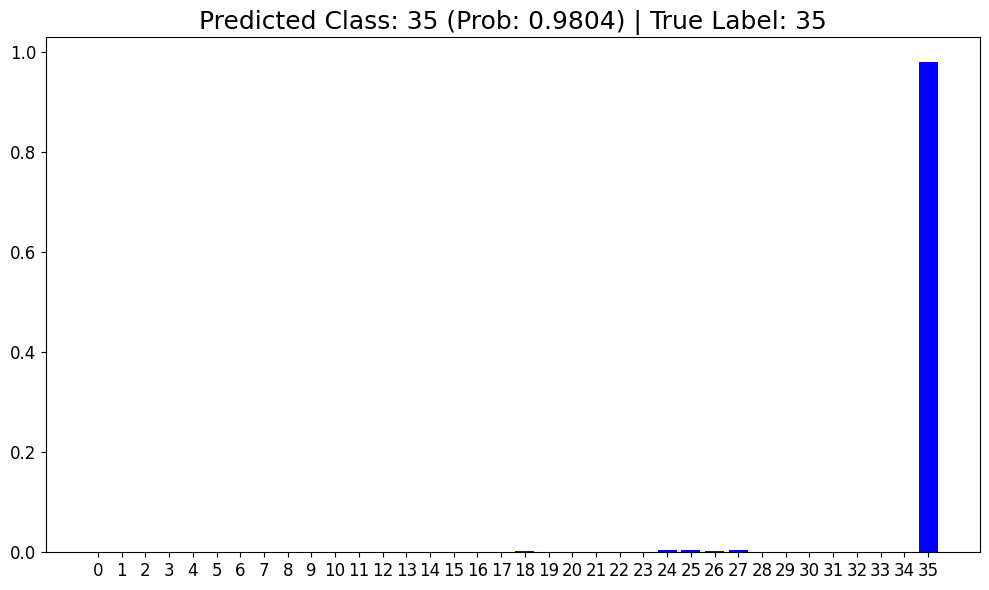

Single sample classification plot saved.


In [100]:
# -------------------------------
# Visualization Functions (inline reimplementation)
# -------------------------------

# 1. Confusion Matrix Plot
conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(n_classes), normalize='true')
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, cmap='gray_r', fmt='.2f',
                 square=True, cbar=True, linewidths=0,
                 annot_kws={"size": 14})
num_rows, num_cols = conf_matrix.shape
rect = Rectangle((0, 0), num_cols, num_rows, fill=False, edgecolor='black', linewidth=2.5)
ax.add_patch(rect)
plt.tight_layout()
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.close()

# 2. Class-wise Accuracy Plot
class_accuracies = []
for class_idx in range(n_classes):
    mask = (all_labels == class_idx)
    if np.sum(mask) == 0:
        class_accuracies.append(0.0)
    else:
        correct = (all_preds[mask] == class_idx).sum()
        class_accuracies.append(correct / np.sum(mask))
class_accuracies = np.array(class_accuracies) * 100
overall_accuracy = accuracy_score(all_labels, all_preds) * 100
sorted_indices = np.argsort(class_accuracies)[::-1]
sorted_accuracies = class_accuracies[sorted_indices]
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})
plt.figure(figsize=(12, 5))
x_positions = np.arange(len(sorted_accuracies))
plt.bar(x_positions, sorted_accuracies, color='blue', label='Accuracy')
plt.xticks(x_positions, sorted_indices, rotation=90)
plt.xlabel('Material/Class ID (sorted)')
plt.ylabel('Accuracy [%]')
plt.axhline(y=np.mean(class_accuracies), color='gray', linestyle='--', label='Mean Accuracy')
plt.title(f'Per-Class Accuracy (Overall: {overall_accuracy:.2f}%)')

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'per_class_accuracy.png'))
plt.close()

# Optionally, save logs
with open(os.path.join(output_dir, 'logs.pkl'), 'wb') as f:
    pickle.dump(logs, f)

print("Logs and plots saved in:", output_dir)

# -------------------------------
# Single Sample Classification & Plotting
# -------------------------------
n=13
# Take a single sample from the validation dataloader
for x_batch, labels in val_loader:
    x_sample = x_batch[n:n+1].to(device)  # shape (1, 1002)
    true_label = labels[n].item()
    break

# Classify the single sample
inn.eval()
gmm.eval()
with torch.no_grad():
    z, log_detJ = inn(x_sample)
    dist = cluster_distances(z, gmm.mu)  # Shape: (1, n_classes)
    y_ = -0.5 * dist
    probs = torch.softmax(y_, dim=1).squeeze(0).cpu().numpy()  # Shape: (n_classes,)

predicted_class = np.argmax(probs)
predicted_prob = probs[predicted_class]

# Plot probability distribution for the single sample
plt.figure(figsize=(10, 6))
plt.bar(np.arange(n_classes), probs, color='blue')
plt.title(f'Predicted Class: {predicted_class} (Prob: {predicted_prob:.4f}) | True Label: {true_label}')
plt.xticks(np.arange(n_classes))
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'single_sample_probabilities.png'))
plt.show()

print("Single sample classification plot saved.")


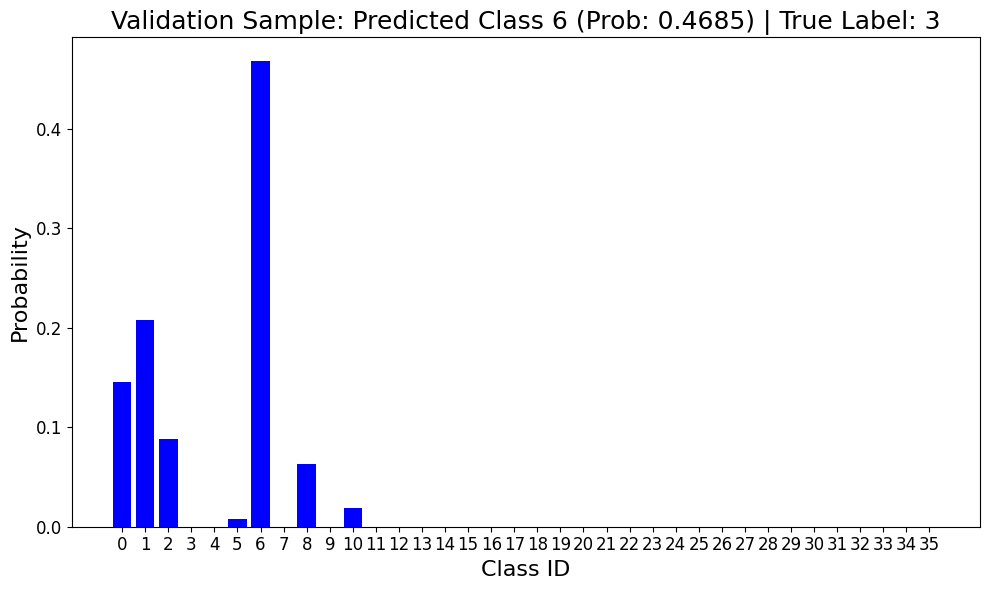

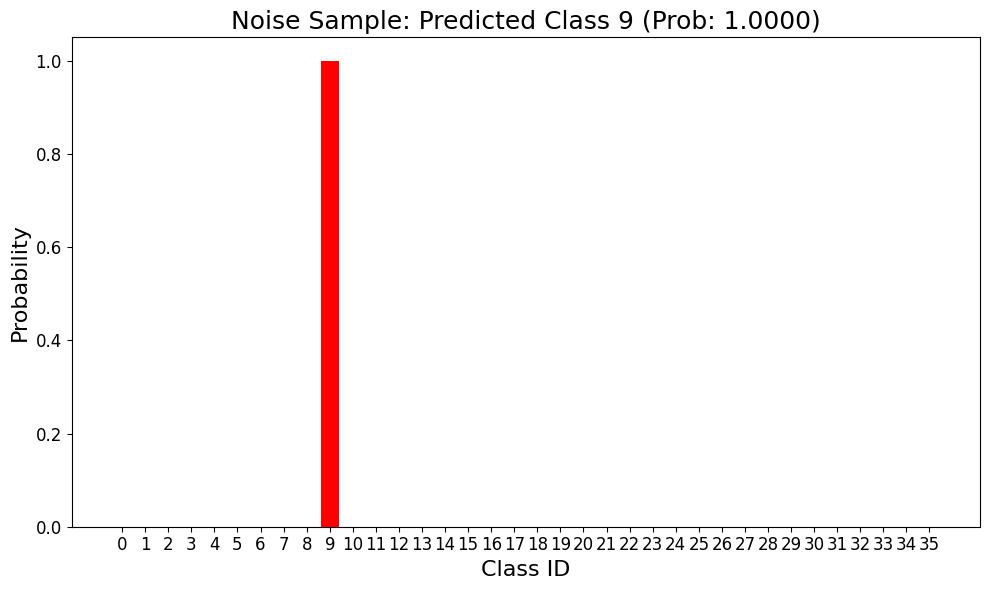

In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# -----------------------
# Choose a random sample from the validation dataloader
# -----------------------
for x_batch, labels in val_loader:
    # Randomly select an index from the current batch
    idx = random.randint(0, x_batch.size(0) - 1)
    x_sample_val = x_batch[idx:idx+1].to(device)  # Ensure shape (1, N_DIM)
    true_label_val = labels[idx].item()
    break  # Only need one batch

# Classify the chosen validation sample
inn.eval()
gmm.eval()
with torch.no_grad():
    z_val, log_detJ_val = inn(x_sample_val)
    dist_val = cluster_distances(z_val, gmm.mu)  # Shape: (1, n_classes)
    y_val = -0.5 * dist_val
    probs_val = torch.softmax(y_val, dim=1).squeeze(0).cpu().numpy()

predicted_class_val = np.argmax(probs_val)
predicted_prob_val  = probs_val[predicted_class_val]

# Plot the probability distribution for the chosen validation sample
plt.figure(figsize=(10, 6))
plt.bar(np.arange(n_classes), probs_val, color='blue')
plt.xlabel('Class ID')
plt.ylabel('Probability')
plt.title(f'Validation Sample: Predicted Class {predicted_class_val} (Prob: {predicted_prob_val:.4f}) | True Label: {true_label_val}')
plt.xticks(np.arange(n_classes))
plt.tight_layout()
plt.show()

# -----------------------
# Generate a random noise sample
# -----------------------
x_noise = torch.randn(1, N_DIM).to(device)  # Generate noise with same dimensions

# Classify the noise sample
with torch.no_grad():
    z_noise, log_detJ_noise = inn(x_noise)
    dist_noise = cluster_distances(z_noise, gmm.mu)  # Shape: (1, n_classes)
    y_noise = -0.5 * dist_noise
    probs_noise = torch.softmax(y_noise, dim=1).squeeze(0).cpu().numpy()

predicted_class_noise = np.argmax(probs_noise)
predicted_prob_noise  = probs_noise[predicted_class_noise]

# Plot the probability distribution for the noise sample
plt.figure(figsize=(10, 6))
plt.bar(np.arange(n_classes), probs_noise, color='red')
plt.xlabel('Class ID')
plt.ylabel('Probability')
plt.title(f'Noise Sample: Predicted Class {predicted_class_noise} (Prob: {predicted_prob_noise:.4f})')
plt.xticks(np.arange(n_classes))
plt.tight_layout()
plt.show()


In [52]:
    
    inn, gmm, logs = train_inn_gmm(
        dataset_path="data/raw/tactmat.h5",  
        n_coupling_blocks=2,
        epochs=40,
        min_beta=2,
        max_beta=2,
        lr=0.001,
        lr_mu=0.001,
        weight_decay=1e-4,
        train_split=0.8,
        n_classes=36,
        hidden_layer_size=512,
        patience=10,
        schedule_type="exponential",
        swap_permute=False,
        output_dir="output_inn"
    )
    

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training loop...


[Epoch 1/40] Train Loss: 4.7736, Val Loss: 4.2918, Val Acc (Top-1): 0.2314, Val Acc (Top-5): 0.6258, L_gen mean: -0.4778, L_cls mean: 2.3056, beta: 2.0000


[Epoch 2/40] Train Loss: 4.0313, Val Loss: 4.2718, Val Acc (Top-1): 0.2711, Val Acc (Top-5): 0.6769, L_gen mean: -0.2568, L_cls mean: 2.2256, beta: 2.0000


[Epoch 3/40] Train Loss: 3.8009, Val Loss: 4.3047, Val Acc (Top-1): 0.2972, Val Acc (Top-5): 0.7221, L_gen mean: -0.0363, L_cls mean: 2.4473, beta: 2.0000


[Epoch 4/40] Train Loss: 3.6995, Val Loss: 4.4682, Val Acc (Top-1): 0.3028, Val Acc (Top-5): 0.7201, L_gen mean: 0.1403, L_cls mean: 2.2443, beta: 2.0000


[Epoch 5/40] Train Loss: 3.5690, Val Loss: 4.5731, Val Acc (Top-1): 0.3002, Val Acc (Top-5): 0.7313, L_gen mean: 0.2240, L_cls mean: 2.3852, beta: 2.0000


[Epoch 6/40] Train Loss: 3.4218, Val Loss: 4.7001, Val Acc (Top-1): 0.3126, Val Acc (Top-5): 0.7403, L_gen mean: 0.2672, L_cls mean: 2.5185, beta: 2.0000


[Epoch 7/40] Train Loss: 3.2678, Val Loss: 4.7077, Val Acc (Top-1): 0.3216, Val Acc (Top-5): 0.7516, L_gen mean: 0.3238, L_cls mean: 1.9988, beta: 2.0000


[Epoch 8/40] Train Loss: 3.0996, Val Loss: 4.8793, Val Acc (Top-1): 0.3194, Val Acc (Top-5): 0.7410, L_gen mean: 0.3533, L_cls mean: 1.8036, beta: 2.0000


[Epoch 9/40] Train Loss: 2.9354, Val Loss: 5.0010, Val Acc (Top-1): 0.3250, Val Acc (Top-5): 0.7529, L_gen mean: 0.3674, L_cls mean: 2.8909, beta: 2.0000


[Epoch 10/40] Train Loss: 2.7845, Val Loss: 5.2024, Val Acc (Top-1): 0.3188, Val Acc (Top-5): 0.7405, L_gen mean: 0.3904, L_cls mean: 2.4486, beta: 2.0000


[Epoch 11/40] Train Loss: 2.6053, Val Loss: 5.4248, Val Acc (Top-1): 0.3121, Val Acc (Top-5): 0.7421, L_gen mean: 0.4032, L_cls mean: 2.1095, beta: 2.0000


[Epoch 12/40] Train Loss: 2.4761, Val Loss: 5.6014, Val Acc (Top-1): 0.3093, Val Acc (Top-5): 0.7360, L_gen mean: 0.4143, L_cls mean: 2.8101, beta: 2.0000


[Epoch 13/40] Train Loss: 2.3075, Val Loss: 5.7792, Val Acc (Top-1): 0.3187, Val Acc (Top-5): 0.7367, L_gen mean: 0.4263, L_cls mean: 2.8549, beta: 2.0000


[Epoch 14/40] Train Loss: 2.1966, Val Loss: 6.1643, Val Acc (Top-1): 0.3082, Val Acc (Top-5): 0.7299, L_gen mean: 0.4393, L_cls mean: 3.3143, beta: 2.0000


[Epoch 15/40] Train Loss: 2.0622, Val Loss: 6.2948, Val Acc (Top-1): 0.3062, Val Acc (Top-5): 0.7331, L_gen mean: 0.4450, L_cls mean: 3.2062, beta: 2.0000


[Epoch 16/40] Train Loss: 1.9439, Val Loss: 6.7040, Val Acc (Top-1): 0.2963, Val Acc (Top-5): 0.7240, L_gen mean: 0.4477, L_cls mean: 3.1096, beta: 2.0000


[Epoch 17/40] Train Loss: 1.8269, Val Loss: 6.8623, Val Acc (Top-1): 0.3071, Val Acc (Top-5): 0.7287, L_gen mean: 0.4546, L_cls mean: 3.4946, beta: 2.0000


[Epoch 18/40] Train Loss: 1.7528, Val Loss: 7.1318, Val Acc (Top-1): 0.3017, Val Acc (Top-5): 0.7237, L_gen mean: 0.4547, L_cls mean: 3.9954, beta: 2.0000


[Epoch 19/40] Train Loss: 1.6496, Val Loss: 7.6672, Val Acc (Top-1): 0.3005, Val Acc (Top-5): 0.7264, L_gen mean: 0.4523, L_cls mean: 2.9086, beta: 2.0000
Early stopping triggered at epoch 19.
Training complete, Best Accuracy:  0.325


ValueError: too many values to unpack (expected 3)

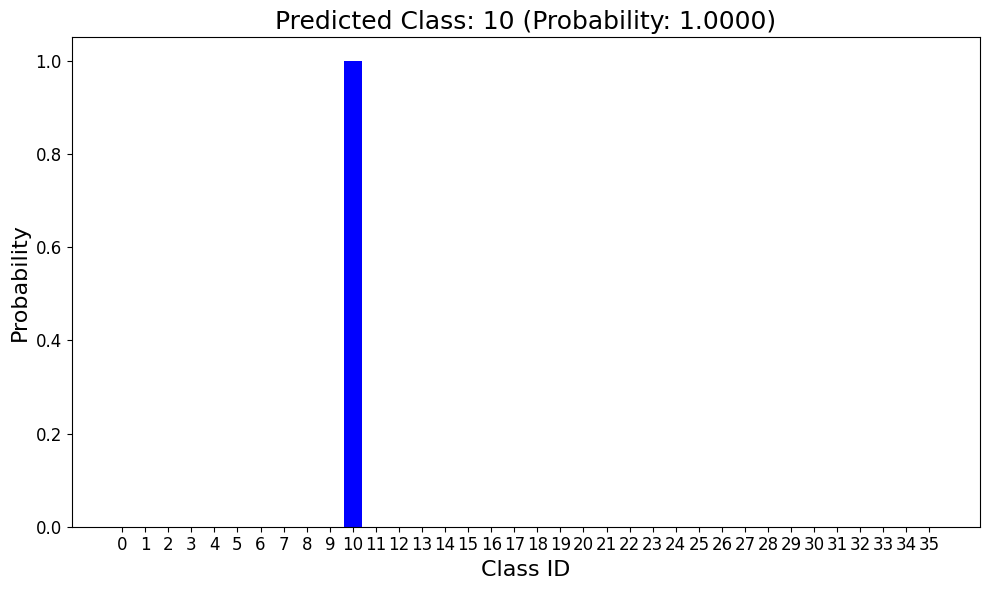

In [101]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assume x_sample is a single sample tensor of shape (1, 1002)
# For example, you could load it from your dataset:
# x_sample, _ = TactileMaterialDataset('data/raw/tactmat.h5')[0]
# x_sample = x_sample.unsqueeze(0).to(device)
# Alternatively, here we use a dummy sample:
x_sample = torch.randn(1, 1002).to(device)

# Set the models to evaluation mode
inn.eval()
gmm.eval()

with torch.no_grad():
    # Pass the sample through the INN to obtain latent representation and log-det
    z, log_detJ = inn(x_sample)
    
    # Compute the distance between z and each class center (mu) in the GMM
    # Note: cluster_distances must be defined in your code (see your previous implementation)
    dist = cluster_distances(z, gmm.mu)  # Shape: (1, 36)
    
    # Convert distances to log-probabilities (negative half distance)
    y_ = -0.5 * dist  # Shape: (1, 36)
    
    # Apply softmax to obtain probability distribution over the 36 classes
    probs = torch.softmax(y_, dim=1).squeeze(0).cpu().numpy()  # Shape: (36,)

# Identify the predicted class and its probability
predicted_class = np.argmax(probs)
predicted_prob = probs[predicted_class]

# Plot the probability distribution
plt.figure(figsize=(10, 6))
plt.bar(np.arange(36), probs, color='blue')
plt.xlabel('Class ID')
plt.ylabel('Probability')
plt.title(f'Predicted Class: {predicted_class} (Probability: {predicted_prob:.4f})')
plt.xticks(np.arange(36))
plt.tight_layout()
plt.show()


In [40]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_samples=1000
device = next(inn.parameters()).device
inn.eval()


Xs = []
Zs = []
Cs = []


count = 0
for x_batch, _ in train_loader:
    x_batch = x_batch.to(device)
    with torch.no_grad():
        z, _ = inn(x_batch)
    

    dist = cluster_distances(z, gmm.mu)
    log_probs = -0.5 * dist
    preds = log_probs.argmax(dim=1)
    
    Xs.append(x_batch.cpu())
    Zs.append(z.cpu())
    Cs.append(preds.cpu())
    
    count += x_batch.size(0)
    if count >= n_samples:
        break

Xs = torch.cat(Xs, dim=0)[:n_samples]
Zs = torch.cat(Zs, dim=0)[:n_samples]
Cs = torch.cat(Cs, dim=0)[:n_samples]

pca = PCA(n_components=50, random_state=42)
Z_pca = pca.fit_transform(Zs.numpy())


tsne = TSNE(n_components=3, perplexity=20, random_state=42)
Z_3d = tsne.fit_transform(Zs.numpy())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(Z_3d[:, 0], Z_3d[:, 1], Z_3d[:, 2],
                     c=Cs.numpy(), cmap='tab20', alpha=0.7)

plt.show()




NameError: name 'train_loader' is not defined

In [ ]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import copy

# Define the hyperparameter search space as a dictionary.
hyper_params = {     
    'min_beta': [0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1,],      
    'max_beta': [0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2],     
    'schedule_type': ["linear", "exponential"]
}

n_experiments = 20

results = []

for exp_num in range(n_experiments):

    exp = {key: random.choice(values) for key, values in hyper_params.items()}
    print(f"Experiment {exp_num+1}/{n_experiments} with parameters: {exp}")

    inn, gmm, logs = train_inn_gmm(
        dataset_path="data/raw/tactmat.h5",
        n_coupling_blocks=exp['n_coupling_blocks'],
        epochs=20,
        max_beta=exp['max_beta'],
        min_beta=exp['min_beta'],
        lr=exp['lr'],
        lr_mu=exp['lr_mu'],
        weight_decay=exp['weight_decay'],
        train_split=0.8,
        n_classes=36,
        hidden_layer_size=exp['hidden_layer_size'],
        patience=exp['patience'],
        schedule_type=exp['schedule_type']
    )
    
    # For simplicity, let's assume we want to minimize validation loss.
    best_val_acc = max(logs['val_accs'])
    print(f"Experiment {exp_num+1} result - Best Val Accuracy: {best_val_acc:.4f}\n")
    
    # Store the hyperparameters and corresponding performance
    results.append((exp, best_val_acc))


results = sorted(results, key=lambda x: x[1])
print("Best hyperparameter configurations:")
for params, loss in results[:5]:
    print(f"Params: {params} - Best Val Loss: {loss:.4f}")


Experiment 1/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.25, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 0.0001, 'weight_decay': 1e-06, 'hidden_layer_size': 128, 'patience': 5, 'schedule_type': 'linear'}


/home/lukas.klostermair/FrEIA/FrEIA/modules/all_in_one_block.py:119: UserWarning: Soft permutation will take a very long time to initialize with 1002 feature channels. Consider using hard permutation instead.
  warnings.warn(("Soft permutation will take a very long time to initialize "


Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:09<00:00, 308.99it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 4.0877, Val Loss: 1.7159, Val Acc (Top-1): 0.1510, Val Acc (Top-5): 0.4727, L_gen mean: 0.2076, L_cls mean: 14.6978, beta: 0.2500


[Epoch 2/20] Train Loss: 1.7162, Val Loss: 1.5476, Val Acc (Top-1): 0.1602, Val Acc (Top-5): 0.4937, L_gen mean: -0.0051, L_cls mean: 8.6979, beta: 0.2875


[Epoch 3/20] Train Loss: 1.3710, Val Loss: 1.1517, Val Acc (Top-1): 0.1777, Val Acc (Top-5): 0.5074, L_gen mean: -0.1164, L_cls mean: 5.4468, beta: 0.3250


[Epoch 4/20] Train Loss: 1.2280, Val Loss: 1.2012, Val Acc (Top-1): 0.1690, Val Acc (Top-5): 0.4865, L_gen mean: -0.2160, L_cls mean: 4.7239, beta: 0.3625


[Epoch 5/20] Train Loss: 1.1181, Val Loss: 1.1207, Val Acc (Top-1): 0.1897, Val Acc (Top-5): 0.5322, L_gen mean: -0.2581, L_cls mean: 4.3346, beta: 0.4000


[Epoch 6/20] Train Loss: 1.0892, Val Loss: 1.1553, Val Acc (Top-1): 0.2035, Val Acc (Top-5): 0.5610, L_gen mean: -0.3251, L_cls mean: 4.7109, beta: 0.4375


[Epoch 7/20] Train Loss: 1.0484, Val Loss: 1.2268, Val Acc (Top-1): 0.2108, Val Acc (Top-5): 0.5669, L_gen mean: -0.3690, L_cls mean: 4.5237, beta: 0.4750


[Epoch 8/20] Train Loss: 1.0227, Val Loss: 1.2132, Val Acc (Top-1): 0.2168, Val Acc (Top-5): 0.5762, L_gen mean: -0.3789, L_cls mean: 2.9149, beta: 0.5125


[Epoch 9/20] Train Loss: 1.0095, Val Loss: 1.3973, Val Acc (Top-1): 0.2036, Val Acc (Top-5): 0.5562, L_gen mean: -0.4284, L_cls mean: 4.1831, beta: 0.5500


[Epoch 10/20] Train Loss: 0.9916, Val Loss: 1.3906, Val Acc (Top-1): 0.2278, Val Acc (Top-5): 0.5958, L_gen mean: -0.4477, L_cls mean: 3.5941, beta: 0.5875
Early stopping triggered at epoch 10.
Training complete (best val loss: 1.1207). Accuracy:  0.1896701388888889
Experiment 1 result - Best Val Accuracy: 0.2278

Experiment 2/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.5, 'max_beta': 0.75, 'lr': 0.001, 'lr_mu': 0.0001, 'weight_decay': 0.0001, 'hidden_layer_size': 256, 'patience': 5, 'schedule_type': 'exponential'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:09<00:00, 288.41it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 7.9365, Val Loss: 4.5941, Val Acc (Top-1): 0.1555, Val Acc (Top-5): 0.4842, L_gen mean: 0.4418, L_cls mean: 3.7287, beta: 0.5000


[Epoch 2/20] Train Loss: 3.8818, Val Loss: 3.4357, Val Acc (Top-1): 0.1633, Val Acc (Top-5): 0.4969, L_gen mean: 0.4373, L_cls mean: 6.6452, beta: 0.5102


[Epoch 3/20] Train Loss: 3.1147, Val Loss: 2.9373, Val Acc (Top-1): 0.1971, Val Acc (Top-5): 0.5334, L_gen mean: 0.4713, L_cls mean: 4.6934, beta: 0.5207


[Epoch 4/20] Train Loss: 2.8043, Val Loss: 2.6538, Val Acc (Top-1): 0.2025, Val Acc (Top-5): 0.5535, L_gen mean: 0.5294, L_cls mean: 2.4684, beta: 0.5314


[Epoch 5/20] Train Loss: 2.6112, Val Loss: 3.5944, Val Acc (Top-1): 0.1999, Val Acc (Top-5): 0.5246, L_gen mean: 0.5672, L_cls mean: 3.6798, beta: 0.5422


[Epoch 6/20] Train Loss: 2.5083, Val Loss: 2.4695, Val Acc (Top-1): 0.2207, Val Acc (Top-5): 0.5821, L_gen mean: 0.6109, L_cls mean: 2.7186, beta: 0.5533


[Epoch 7/20] Train Loss: 2.4389, Val Loss: 2.4812, Val Acc (Top-1): 0.2234, Val Acc (Top-5): 0.5798, L_gen mean: 0.6361, L_cls mean: 2.5010, beta: 0.5647


[Epoch 8/20] Train Loss: 2.4035, Val Loss: 2.5305, Val Acc (Top-1): 0.2233, Val Acc (Top-5): 0.5906, L_gen mean: 0.6683, L_cls mean: 2.7045, beta: 0.5762


[Epoch 9/20] Train Loss: 2.3458, Val Loss: 2.3920, Val Acc (Top-1): 0.2420, Val Acc (Top-5): 0.6269, L_gen mean: 0.6872, L_cls mean: 2.5229, beta: 0.5880


[Epoch 10/20] Train Loss: 2.3290, Val Loss: 3.0196, Val Acc (Top-1): 0.2191, Val Acc (Top-5): 0.5687, L_gen mean: 0.7115, L_cls mean: 3.4397, beta: 0.6001


[Epoch 11/20] Train Loss: 2.3071, Val Loss: 2.5174, Val Acc (Top-1): 0.2482, Val Acc (Top-5): 0.6237, L_gen mean: 0.7138, L_cls mean: 2.5798, beta: 0.6124


[Epoch 12/20] Train Loss: 2.3132, Val Loss: 2.7614, Val Acc (Top-1): 0.2174, Val Acc (Top-5): 0.5874, L_gen mean: 0.7326, L_cls mean: 3.1600, beta: 0.6249


[Epoch 13/20] Train Loss: 2.2862, Val Loss: 2.4520, Val Acc (Top-1): 0.2377, Val Acc (Top-5): 0.6352, L_gen mean: 0.7365, L_cls mean: 2.6357, beta: 0.6377


[Epoch 14/20] Train Loss: 2.3016, Val Loss: 2.5268, Val Acc (Top-1): 0.2504, Val Acc (Top-5): 0.6441, L_gen mean: 0.7441, L_cls mean: 2.4526, beta: 0.6508
Early stopping triggered at epoch 14.
Training complete (best val loss: 2.3920). Accuracy:  0.2420138888888889
Experiment 2 result - Best Val Accuracy: 0.2504

Experiment 3/20 with parameters: {'n_coupling_blocks': 4, 'min_beta': 0.25, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 5e-05, 'weight_decay': 1e-06, 'hidden_layer_size': 512, 'patience': 5, 'schedule_type': 'linear'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:24<00:00, 118.63it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 4.7005, Val Loss: 2.6700, Val Acc (Top-1): 0.1513, Val Acc (Top-5): 0.4770, L_gen mean: 0.2343, L_cls mean: 3.9664, beta: 0.2500


[Epoch 2/20] Train Loss: 2.2973, Val Loss: 1.7558, Val Acc (Top-1): 0.1810, Val Acc (Top-5): 0.5109, L_gen mean: 0.1320, L_cls mean: 6.1757, beta: 0.2875


[Epoch 3/20] Train Loss: 1.7350, Val Loss: 1.9169, Val Acc (Top-1): 0.1745, Val Acc (Top-5): 0.5131, L_gen mean: -0.0693, L_cls mean: 7.9367, beta: 0.3250


[Epoch 4/20] Train Loss: 1.5136, Val Loss: 1.4124, Val Acc (Top-1): 0.2088, Val Acc (Top-5): 0.5558, L_gen mean: -0.1656, L_cls mean: 5.2013, beta: 0.3625


[Epoch 5/20] Train Loss: 1.3500, Val Loss: 1.4703, Val Acc (Top-1): 0.1993, Val Acc (Top-5): 0.5571, L_gen mean: -0.1946, L_cls mean: 6.2569, beta: 0.4000


[Epoch 6/20] Train Loss: 1.2372, Val Loss: 1.4924, Val Acc (Top-1): 0.2140, Val Acc (Top-5): 0.5782, L_gen mean: -0.2944, L_cls mean: 3.1328, beta: 0.4375


[Epoch 7/20] Train Loss: 1.1873, Val Loss: 1.4255, Val Acc (Top-1): 0.2357, Val Acc (Top-5): 0.6092, L_gen mean: -0.3082, L_cls mean: 3.8328, beta: 0.4750


[Epoch 8/20] Train Loss: 1.1255, Val Loss: 1.5970, Val Acc (Top-1): 0.2299, Val Acc (Top-5): 0.6056, L_gen mean: -0.3937, L_cls mean: 3.5682, beta: 0.5125


[Epoch 9/20] Train Loss: 1.0481, Val Loss: 1.7989, Val Acc (Top-1): 0.2370, Val Acc (Top-5): 0.6093, L_gen mean: -0.3919, L_cls mean: 4.2542, beta: 0.5500
Early stopping triggered at epoch 9.
Training complete (best val loss: 1.4124). Accuracy:  0.2087673611111111
Experiment 3 result - Best Val Accuracy: 0.2370

Experiment 4/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.5, 'max_beta': 1.25, 'lr': 0.001, 'lr_mu': 0.0001, 'weight_decay': 1e-05, 'hidden_layer_size': 256, 'patience': 10, 'schedule_type': 'exponential'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:11<00:00, 245.86it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 7.2998, Val Loss: 4.0097, Val Acc (Top-1): 0.1530, Val Acc (Top-5): 0.4723, L_gen mean: 0.1271, L_cls mean: 6.3723, beta: 0.5000


[Epoch 2/20] Train Loss: 3.4070, Val Loss: 3.3398, Val Acc (Top-1): 0.1635, Val Acc (Top-5): 0.4846, L_gen mean: 0.0072, L_cls mean: 4.6409, beta: 0.5234


[Epoch 3/20] Train Loss: 2.6471, Val Loss: 2.5596, Val Acc (Top-1): 0.1947, Val Acc (Top-5): 0.5161, L_gen mean: -0.1481, L_cls mean: 4.7123, beta: 0.5480


[Epoch 4/20] Train Loss: 2.2308, Val Loss: 2.2598, Val Acc (Top-1): 0.2031, Val Acc (Top-5): 0.5527, L_gen mean: -0.2215, L_cls mean: 4.7479, beta: 0.5737


[Epoch 5/20] Train Loss: 2.0073, Val Loss: 1.9738, Val Acc (Top-1): 0.2252, Val Acc (Top-5): 0.5849, L_gen mean: -0.2674, L_cls mean: 2.8642, beta: 0.6006


[Epoch 6/20] Train Loss: 1.8139, Val Loss: 2.1538, Val Acc (Top-1): 0.2159, Val Acc (Top-5): 0.5681, L_gen mean: -0.3134, L_cls mean: 2.9836, beta: 0.6287


[Epoch 7/20] Train Loss: 1.7140, Val Loss: 2.1113, Val Acc (Top-1): 0.2247, Val Acc (Top-5): 0.5878, L_gen mean: -0.3302, L_cls mean: 3.9379, beta: 0.6582


[Epoch 8/20] Train Loss: 1.6423, Val Loss: 1.8649, Val Acc (Top-1): 0.2414, Val Acc (Top-5): 0.6090, L_gen mean: -0.3647, L_cls mean: 2.8195, beta: 0.6890


[Epoch 9/20] Train Loss: 1.5857, Val Loss: 2.0664, Val Acc (Top-1): 0.2305, Val Acc (Top-5): 0.6082, L_gen mean: -0.3800, L_cls mean: 2.7200, beta: 0.7213


[Epoch 10/20] Train Loss: 1.5585, Val Loss: 2.1164, Val Acc (Top-1): 0.2280, Val Acc (Top-5): 0.5951, L_gen mean: -0.3943, L_cls mean: 3.0881, beta: 0.7552


[Epoch 11/20] Train Loss: 1.5127, Val Loss: 2.1522, Val Acc (Top-1): 0.2378, Val Acc (Top-5): 0.6167, L_gen mean: -0.4100, L_cls mean: 3.4314, beta: 0.7906


[Epoch 12/20] Train Loss: 1.5029, Val Loss: 2.0588, Val Acc (Top-1): 0.2576, Val Acc (Top-5): 0.6424, L_gen mean: -0.4278, L_cls mean: 2.9591, beta: 0.8276


[Epoch 13/20] Train Loss: 1.4757, Val Loss: 2.2726, Val Acc (Top-1): 0.2643, Val Acc (Top-5): 0.6440, L_gen mean: -0.4417, L_cls mean: 2.5618, beta: 0.8664


[Epoch 14/20] Train Loss: 1.4834, Val Loss: 2.5691, Val Acc (Top-1): 0.2510, Val Acc (Top-5): 0.6287, L_gen mean: -0.4493, L_cls mean: 3.2590, beta: 0.9070


[Epoch 15/20] Train Loss: 1.4681, Val Loss: 2.5382, Val Acc (Top-1): 0.2621, Val Acc (Top-5): 0.6391, L_gen mean: -0.4636, L_cls mean: 2.8200, beta: 0.9496


[Epoch 16/20] Train Loss: 1.4776, Val Loss: 2.7720, Val Acc (Top-1): 0.2621, Val Acc (Top-5): 0.6340, L_gen mean: -0.4740, L_cls mean: 3.0259, beta: 0.9941


[Epoch 17/20] Train Loss: 1.5084, Val Loss: 2.8149, Val Acc (Top-1): 0.2672, Val Acc (Top-5): 0.6663, L_gen mean: -0.4764, L_cls mean: 3.0861, beta: 1.0407


[Epoch 18/20] Train Loss: 1.4995, Val Loss: 2.9847, Val Acc (Top-1): 0.2627, Val Acc (Top-5): 0.6546, L_gen mean: -0.4753, L_cls mean: 2.3208, beta: 1.0895
Early stopping triggered at epoch 18.
Training complete (best val loss: 1.8649). Accuracy:  0.24140625
Experiment 4 result - Best Val Accuracy: 0.2672

Experiment 5/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.25, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 0.0001, 'weight_decay': 1e-06, 'hidden_layer_size': 256, 'patience': 10, 'schedule_type': 'exponential'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:09<00:00, 300.31it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 4.4139, Val Loss: 3.3971, Val Acc (Top-1): 0.1226, Val Acc (Top-5): 0.4249, L_gen mean: 0.0402, L_cls mean: 9.9842, beta: 0.2500


[Epoch 2/20] Train Loss: 1.8420, Val Loss: 1.7408, Val Acc (Top-1): 0.1641, Val Acc (Top-5): 0.4852, L_gen mean: -0.1821, L_cls mean: 6.3168, beta: 0.2679


[Epoch 3/20] Train Loss: 1.3777, Val Loss: 1.1781, Val Acc (Top-1): 0.1715, Val Acc (Top-5): 0.5160, L_gen mean: -0.2766, L_cls mean: 4.0703, beta: 0.2872


[Epoch 4/20] Train Loss: 1.1053, Val Loss: 1.1066, Val Acc (Top-1): 0.1944, Val Acc (Top-5): 0.5600, L_gen mean: -0.3258, L_cls mean: 3.0517, beta: 0.3078


[Epoch 5/20] Train Loss: 0.9706, Val Loss: 0.9309, Val Acc (Top-1): 0.2030, Val Acc (Top-5): 0.5556, L_gen mean: -0.4102, L_cls mean: 3.5758, beta: 0.3299


[Epoch 6/20] Train Loss: 0.8596, Val Loss: 1.2407, Val Acc (Top-1): 0.1880, Val Acc (Top-5): 0.5249, L_gen mean: -0.4586, L_cls mean: 3.9810, beta: 0.3536


[Epoch 7/20] Train Loss: 0.7833, Val Loss: 0.9599, Val Acc (Top-1): 0.2029, Val Acc (Top-5): 0.5547, L_gen mean: -0.4975, L_cls mean: 4.3633, beta: 0.3789


[Epoch 8/20] Train Loss: 0.7286, Val Loss: 0.9128, Val Acc (Top-1): 0.2260, Val Acc (Top-5): 0.5862, L_gen mean: -0.5248, L_cls mean: 3.9089, beta: 0.4061


[Epoch 9/20] Train Loss: 0.6939, Val Loss: 1.0224, Val Acc (Top-1): 0.2294, Val Acc (Top-5): 0.5900, L_gen mean: -0.5522, L_cls mean: 4.4122, beta: 0.4353


[Epoch 10/20] Train Loss: 0.6608, Val Loss: 1.0892, Val Acc (Top-1): 0.2216, Val Acc (Top-5): 0.5789, L_gen mean: -0.5814, L_cls mean: 4.0004, beta: 0.4665


[Epoch 11/20] Train Loss: 0.6562, Val Loss: 1.1000, Val Acc (Top-1): 0.2459, Val Acc (Top-5): 0.6181, L_gen mean: -0.6017, L_cls mean: 4.1028, beta: 0.5000


[Epoch 12/20] Train Loss: 0.6373, Val Loss: 1.3570, Val Acc (Top-1): 0.2158, Val Acc (Top-5): 0.5957, L_gen mean: -0.6101, L_cls mean: 4.8563, beta: 0.5359


[Epoch 13/20] Train Loss: 0.6346, Val Loss: 1.1791, Val Acc (Top-1): 0.2517, Val Acc (Top-5): 0.6344, L_gen mean: -0.6250, L_cls mean: 3.7562, beta: 0.5743


[Epoch 14/20] Train Loss: 0.6556, Val Loss: 1.2987, Val Acc (Top-1): 0.2484, Val Acc (Top-5): 0.6304, L_gen mean: -0.6330, L_cls mean: 3.9546, beta: 0.6156


[Epoch 15/20] Train Loss: 0.6520, Val Loss: 1.7668, Val Acc (Top-1): 0.2291, Val Acc (Top-5): 0.6169, L_gen mean: -0.6413, L_cls mean: 3.3341, beta: 0.6598


[Epoch 16/20] Train Loss: 0.6566, Val Loss: 1.5902, Val Acc (Top-1): 0.2632, Val Acc (Top-5): 0.6548, L_gen mean: -0.6616, L_cls mean: 2.2303, beta: 0.7071


[Epoch 17/20] Train Loss: 0.7025, Val Loss: 1.6960, Val Acc (Top-1): 0.2632, Val Acc (Top-5): 0.6591, L_gen mean: -0.6727, L_cls mean: 2.9903, beta: 0.7579


[Epoch 18/20] Train Loss: 0.7044, Val Loss: 2.0938, Val Acc (Top-1): 0.2536, Val Acc (Top-5): 0.6439, L_gen mean: -0.6878, L_cls mean: 3.9054, beta: 0.8123
Early stopping triggered at epoch 18.
Training complete (best val loss: 0.9128). Accuracy:  0.2259548611111111
Experiment 5 result - Best Val Accuracy: 0.2632

Experiment 6/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.25, 'max_beta': 1.25, 'lr': 0.001, 'lr_mu': 5e-05, 'weight_decay': 1e-06, 'hidden_layer_size': 128, 'patience': 5, 'schedule_type': 'exponential'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:09<00:00, 319.22it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 4.2968, Val Loss: 2.0772, Val Acc (Top-1): 0.1547, Val Acc (Top-5): 0.4796, L_gen mean: -0.0741, L_cls mean: 8.6186, beta: 0.2500


[Epoch 2/20] Train Loss: 1.9595, Val Loss: 1.5735, Val Acc (Top-1): 0.1607, Val Acc (Top-5): 0.4744, L_gen mean: -0.1950, L_cls mean: 7.5011, beta: 0.2709


[Epoch 3/20] Train Loss: 1.4610, Val Loss: 1.3122, Val Acc (Top-1): 0.1708, Val Acc (Top-5): 0.5062, L_gen mean: -0.3150, L_cls mean: 5.9313, beta: 0.2937


[Epoch 4/20] Train Loss: 1.2127, Val Loss: 1.1665, Val Acc (Top-1): 0.1971, Val Acc (Top-5): 0.5394, L_gen mean: -0.3973, L_cls mean: 5.2290, beta: 0.3183


[Epoch 5/20] Train Loss: 1.1040, Val Loss: 1.1645, Val Acc (Top-1): 0.1944, Val Acc (Top-5): 0.5414, L_gen mean: -0.4397, L_cls mean: 3.9839, beta: 0.3449


[Epoch 6/20] Train Loss: 1.0029, Val Loss: 1.2127, Val Acc (Top-1): 0.2126, Val Acc (Top-5): 0.5543, L_gen mean: -0.4957, L_cls mean: 2.9987, beta: 0.3738


[Epoch 7/20] Train Loss: 0.9443, Val Loss: 1.1220, Val Acc (Top-1): 0.2083, Val Acc (Top-5): 0.5591, L_gen mean: -0.5322, L_cls mean: 4.8318, beta: 0.4052


[Epoch 8/20] Train Loss: 0.9173, Val Loss: 1.1141, Val Acc (Top-1): 0.2199, Val Acc (Top-5): 0.5747, L_gen mean: -0.5506, L_cls mean: 4.3255, beta: 0.4391


[Epoch 9/20] Train Loss: 0.9197, Val Loss: 1.3320, Val Acc (Top-1): 0.2220, Val Acc (Top-5): 0.5724, L_gen mean: -0.5935, L_cls mean: 3.3063, beta: 0.4759


[Epoch 10/20] Train Loss: 0.9117, Val Loss: 1.3382, Val Acc (Top-1): 0.2237, Val Acc (Top-5): 0.5794, L_gen mean: -0.5998, L_cls mean: 3.5032, beta: 0.5158


[Epoch 11/20] Train Loss: 0.9347, Val Loss: 1.4597, Val Acc (Top-1): 0.2355, Val Acc (Top-5): 0.6058, L_gen mean: -0.6034, L_cls mean: 3.7111, beta: 0.5590


[Epoch 12/20] Train Loss: 0.9593, Val Loss: 1.9645, Val Acc (Top-1): 0.2169, Val Acc (Top-5): 0.5731, L_gen mean: -0.6460, L_cls mean: 2.4919, beta: 0.6059


[Epoch 13/20] Train Loss: 1.0369, Val Loss: 1.6982, Val Acc (Top-1): 0.2458, Val Acc (Top-5): 0.6210, L_gen mean: -0.6378, L_cls mean: 2.5367, beta: 0.6566
Early stopping triggered at epoch 13.
Training complete (best val loss: 1.1141). Accuracy:  0.21987847222222223
Experiment 6 result - Best Val Accuracy: 0.2458

Experiment 7/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.75, 'max_beta': 1.0, 'lr': 0.001, 'lr_mu': 5e-05, 'weight_decay': 0.0001, 'hidden_layer_size': 256, 'patience': 10, 'schedule_type': 'linear'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:17<00:00, 167.55it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 14.8266, Val Loss: 7.7853, Val Acc (Top-1): 0.1660, Val Acc (Top-5): 0.4855, L_gen mean: 0.9003, L_cls mean: 6.8736, beta: 0.7500


[Epoch 2/20] Train Loss: 7.2052, Val Loss: 5.7837, Val Acc (Top-1): 0.1742, Val Acc (Top-5): 0.5035, L_gen mean: 0.8102, L_cls mean: 6.6180, beta: 0.7625


[Epoch 3/20] Train Loss: 5.6365, Val Loss: 5.4303, Val Acc (Top-1): 0.1779, Val Acc (Top-5): 0.5191, L_gen mean: 0.7095, L_cls mean: 8.4299, beta: 0.7750


[Epoch 4/20] Train Loss: 5.1139, Val Loss: 4.9485, Val Acc (Top-1): 0.1824, Val Acc (Top-5): 0.5323, L_gen mean: 0.7459, L_cls mean: 3.7746, beta: 0.7875


[Epoch 5/20] Train Loss: 4.5767, Val Loss: 4.2374, Val Acc (Top-1): 0.2091, Val Acc (Top-5): 0.5745, L_gen mean: 0.7396, L_cls mean: 3.9898, beta: 0.8000


[Epoch 6/20] Train Loss: 4.2963, Val Loss: 4.2688, Val Acc (Top-1): 0.2024, Val Acc (Top-5): 0.5569, L_gen mean: 0.7274, L_cls mean: 4.0427, beta: 0.8125


[Epoch 7/20] Train Loss: 4.0493, Val Loss: 4.3210, Val Acc (Top-1): 0.2148, Val Acc (Top-5): 0.5732, L_gen mean: 0.7305, L_cls mean: 2.3862, beta: 0.8250


[Epoch 8/20] Train Loss: 3.9134, Val Loss: 3.8887, Val Acc (Top-1): 0.2245, Val Acc (Top-5): 0.5865, L_gen mean: 0.7682, L_cls mean: 2.9293, beta: 0.8375


[Epoch 9/20] Train Loss: 3.8220, Val Loss: 4.1363, Val Acc (Top-1): 0.2150, Val Acc (Top-5): 0.5694, L_gen mean: 0.7620, L_cls mean: 2.8811, beta: 0.8500


[Epoch 10/20] Train Loss: 3.6615, Val Loss: 3.8211, Val Acc (Top-1): 0.2301, Val Acc (Top-5): 0.6053, L_gen mean: 0.7746, L_cls mean: 2.4298, beta: 0.8625


[Epoch 11/20] Train Loss: 3.6496, Val Loss: 3.7983, Val Acc (Top-1): 0.2481, Val Acc (Top-5): 0.6174, L_gen mean: 0.7849, L_cls mean: 1.9781, beta: 0.8750


[Epoch 12/20] Train Loss: 3.5787, Val Loss: 3.9105, Val Acc (Top-1): 0.2512, Val Acc (Top-5): 0.6159, L_gen mean: 0.8033, L_cls mean: 3.0035, beta: 0.8875


[Epoch 13/20] Train Loss: 3.5032, Val Loss: 4.2066, Val Acc (Top-1): 0.2413, Val Acc (Top-5): 0.6049, L_gen mean: 0.7814, L_cls mean: 2.6160, beta: 0.9000


[Epoch 14/20] Train Loss: 3.4932, Val Loss: 4.1428, Val Acc (Top-1): 0.2336, Val Acc (Top-5): 0.6136, L_gen mean: 0.8014, L_cls mean: 2.1493, beta: 0.9125


[Epoch 15/20] Train Loss: 3.4425, Val Loss: 4.6159, Val Acc (Top-1): 0.2435, Val Acc (Top-5): 0.5958, L_gen mean: 0.8139, L_cls mean: 2.3768, beta: 0.9250


[Epoch 16/20] Train Loss: 3.4153, Val Loss: 3.8661, Val Acc (Top-1): 0.2560, Val Acc (Top-5): 0.6283, L_gen mean: 0.8240, L_cls mean: 2.6851, beta: 0.9375


[Epoch 17/20] Train Loss: 3.3741, Val Loss: 3.8491, Val Acc (Top-1): 0.2579, Val Acc (Top-5): 0.6290, L_gen mean: 0.8325, L_cls mean: 2.8937, beta: 0.9500


[Epoch 18/20] Train Loss: 3.3756, Val Loss: 4.3878, Val Acc (Top-1): 0.2447, Val Acc (Top-5): 0.6139, L_gen mean: 0.8354, L_cls mean: 2.0421, beta: 0.9625


[Epoch 19/20] Train Loss: 3.3985, Val Loss: 3.8248, Val Acc (Top-1): 0.2679, Val Acc (Top-5): 0.6540, L_gen mean: 0.8403, L_cls mean: 2.3425, beta: 0.9750


[Epoch 20/20] Train Loss: 3.3421, Val Loss: 3.8835, Val Acc (Top-1): 0.2701, Val Acc (Top-5): 0.6472, L_gen mean: 0.8558, L_cls mean: 2.9818, beta: 0.9875
Training complete (best val loss: 3.7983). Accuracy:  0.24809027777777778
Experiment 7 result - Best Val Accuracy: 0.2701

Experiment 8/20 with parameters: {'n_coupling_blocks': 4, 'min_beta': 0.5, 'max_beta': 0.75, 'lr': 0.0005, 'lr_mu': 5e-05, 'weight_decay': 0.0001, 'hidden_layer_size': 128, 'patience': 10, 'schedule_type': 'exponential'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:17<00:00, 166.87it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 9.5610, Val Loss: 4.5746, Val Acc (Top-1): 0.1471, Val Acc (Top-5): 0.4591, L_gen mean: 1.3656, L_cls mean: 11.5281, beta: 0.5000


[Epoch 2/20] Train Loss: 4.2723, Val Loss: 3.7848, Val Acc (Top-1): 0.1542, Val Acc (Top-5): 0.4766, L_gen mean: 1.0364, L_cls mean: 5.7078, beta: 0.5102


[Epoch 3/20] Train Loss: 3.3937, Val Loss: 4.3498, Val Acc (Top-1): 0.1709, Val Acc (Top-5): 0.4905, L_gen mean: 0.5972, L_cls mean: 16.3121, beta: 0.5207


[Epoch 4/20] Train Loss: 2.9727, Val Loss: 2.7051, Val Acc (Top-1): 0.1775, Val Acc (Top-5): 0.5201, L_gen mean: 0.6564, L_cls mean: 5.7460, beta: 0.5314


[Epoch 5/20] Train Loss: 2.8108, Val Loss: 2.8532, Val Acc (Top-1): 0.2028, Val Acc (Top-5): 0.5311, L_gen mean: 0.6506, L_cls mean: 7.4970, beta: 0.5422


[Epoch 6/20] Train Loss: 2.7016, Val Loss: 2.7258, Val Acc (Top-1): 0.1972, Val Acc (Top-5): 0.5441, L_gen mean: 0.6963, L_cls mean: 4.4268, beta: 0.5533


[Epoch 7/20] Train Loss: 2.5992, Val Loss: 3.3094, Val Acc (Top-1): 0.1908, Val Acc (Top-5): 0.5213, L_gen mean: 0.6945, L_cls mean: 7.8768, beta: 0.5647


[Epoch 8/20] Train Loss: 2.5641, Val Loss: 2.7082, Val Acc (Top-1): 0.2237, Val Acc (Top-5): 0.5748, L_gen mean: 0.7680, L_cls mean: 5.5446, beta: 0.5762


[Epoch 9/20] Train Loss: 2.5187, Val Loss: 2.6472, Val Acc (Top-1): 0.2192, Val Acc (Top-5): 0.5865, L_gen mean: 0.7098, L_cls mean: 5.3702, beta: 0.5880


[Epoch 10/20] Train Loss: 2.4518, Val Loss: 2.6845, Val Acc (Top-1): 0.2359, Val Acc (Top-5): 0.5957, L_gen mean: 0.7824, L_cls mean: 4.0785, beta: 0.6001


[Epoch 11/20] Train Loss: 2.5295, Val Loss: 2.8865, Val Acc (Top-1): 0.2356, Val Acc (Top-5): 0.5885, L_gen mean: 0.8497, L_cls mean: 5.1039, beta: 0.6124


[Epoch 12/20] Train Loss: 2.4661, Val Loss: 2.6644, Val Acc (Top-1): 0.2455, Val Acc (Top-5): 0.6221, L_gen mean: 0.8352, L_cls mean: 5.3244, beta: 0.6249


[Epoch 13/20] Train Loss: 2.4588, Val Loss: 2.6409, Val Acc (Top-1): 0.2510, Val Acc (Top-5): 0.6126, L_gen mean: 0.8190, L_cls mean: 4.3656, beta: 0.6377


[Epoch 14/20] Train Loss: 2.4358, Val Loss: 2.6539, Val Acc (Top-1): 0.2650, Val Acc (Top-5): 0.6386, L_gen mean: 0.8522, L_cls mean: 2.7085, beta: 0.6508


[Epoch 15/20] Train Loss: 2.4589, Val Loss: 2.8762, Val Acc (Top-1): 0.2484, Val Acc (Top-5): 0.6166, L_gen mean: 0.8816, L_cls mean: 4.5249, beta: 0.6641


[Epoch 16/20] Train Loss: 2.4465, Val Loss: 3.3474, Val Acc (Top-1): 0.2389, Val Acc (Top-5): 0.6111, L_gen mean: 0.8427, L_cls mean: 8.0839, beta: 0.6777


[Epoch 17/20] Train Loss: 2.4878, Val Loss: 2.8717, Val Acc (Top-1): 0.2578, Val Acc (Top-5): 0.6203, L_gen mean: 0.9094, L_cls mean: 4.9819, beta: 0.6916


[Epoch 18/20] Train Loss: 2.4679, Val Loss: 2.9425, Val Acc (Top-1): 0.2572, Val Acc (Top-5): 0.6325, L_gen mean: 0.9039, L_cls mean: 2.6668, beta: 0.7057


[Epoch 19/20] Train Loss: 2.5179, Val Loss: 3.1391, Val Acc (Top-1): 0.2590, Val Acc (Top-5): 0.6285, L_gen mean: 0.9108, L_cls mean: 4.4161, beta: 0.7202


[Epoch 20/20] Train Loss: 2.5036, Val Loss: 2.9435, Val Acc (Top-1): 0.2671, Val Acc (Top-5): 0.6403, L_gen mean: 0.9293, L_cls mean: 3.3151, beta: 0.7349
Training complete (best val loss: 2.6409). Accuracy:  0.2509548611111111
Experiment 8 result - Best Val Accuracy: 0.2671

Experiment 9/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.5, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 0.0001, 'weight_decay': 1e-06, 'hidden_layer_size': 512, 'patience': 10, 'schedule_type': 'exponential'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:12<00:00, 235.85it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 10.3677, Val Loss: 5.4159, Val Acc (Top-1): 0.1491, Val Acc (Top-5): 0.4584, L_gen mean: 0.3849, L_cls mean: 8.6881, beta: 0.5000


[Epoch 2/20] Train Loss: 4.8675, Val Loss: 4.0039, Val Acc (Top-1): 0.1702, Val Acc (Top-5): 0.5030, L_gen mean: 0.1659, L_cls mean: 4.9362, beta: 0.5176


[Epoch 3/20] Train Loss: 3.7813, Val Loss: 3.1956, Val Acc (Top-1): 0.1895, Val Acc (Top-5): 0.5241, L_gen mean: 0.0074, L_cls mean: 4.6681, beta: 0.5359


[Epoch 4/20] Train Loss: 3.1609, Val Loss: 3.1320, Val Acc (Top-1): 0.1917, Val Acc (Top-5): 0.5372, L_gen mean: -0.0881, L_cls mean: 4.4813, beta: 0.5548


[Epoch 5/20] Train Loss: 2.7456, Val Loss: 2.6917, Val Acc (Top-1): 0.1906, Val Acc (Top-5): 0.5396, L_gen mean: -0.1858, L_cls mean: 5.0564, beta: 0.5743


[Epoch 6/20] Train Loss: 2.4024, Val Loss: 2.9062, Val Acc (Top-1): 0.2030, Val Acc (Top-5): 0.5423, L_gen mean: -0.2498, L_cls mean: 5.3311, beta: 0.5946


[Epoch 7/20] Train Loss: 2.2168, Val Loss: 2.5875, Val Acc (Top-1): 0.2187, Val Acc (Top-5): 0.5629, L_gen mean: -0.3320, L_cls mean: 4.5983, beta: 0.6156


[Epoch 8/20] Train Loss: 1.9912, Val Loss: 2.6435, Val Acc (Top-1): 0.2060, Val Acc (Top-5): 0.5589, L_gen mean: -0.3552, L_cls mean: 3.9176, beta: 0.6373


[Epoch 9/20] Train Loss: 1.8491, Val Loss: 2.3093, Val Acc (Top-1): 0.2306, Val Acc (Top-5): 0.5854, L_gen mean: -0.3939, L_cls mean: 4.7154, beta: 0.6598


[Epoch 10/20] Train Loss: 1.7318, Val Loss: 2.9244, Val Acc (Top-1): 0.2379, Val Acc (Top-5): 0.5813, L_gen mean: -0.4383, L_cls mean: 5.0347, beta: 0.6830


[Epoch 11/20] Train Loss: 1.5716, Val Loss: 3.0787, Val Acc (Top-1): 0.2153, Val Acc (Top-5): 0.5614, L_gen mean: -0.4680, L_cls mean: 4.2873, beta: 0.7071


[Epoch 12/20] Train Loss: 1.5194, Val Loss: 2.3743, Val Acc (Top-1): 0.2489, Val Acc (Top-5): 0.6354, L_gen mean: -0.5109, L_cls mean: 3.9210, beta: 0.7320


[Epoch 13/20] Train Loss: 1.4265, Val Loss: 2.5456, Val Acc (Top-1): 0.2528, Val Acc (Top-5): 0.6269, L_gen mean: -0.5224, L_cls mean: 4.5952, beta: 0.7579


[Epoch 14/20] Train Loss: 1.3588, Val Loss: 3.0509, Val Acc (Top-1): 0.2475, Val Acc (Top-5): 0.6122, L_gen mean: -0.5493, L_cls mean: 4.2269, beta: 0.7846


[Epoch 15/20] Train Loss: 1.2805, Val Loss: 2.5801, Val Acc (Top-1): 0.2603, Val Acc (Top-5): 0.6386, L_gen mean: -0.5655, L_cls mean: 4.0252, beta: 0.8123


[Epoch 16/20] Train Loss: 1.2222, Val Loss: 2.8615, Val Acc (Top-1): 0.2622, Val Acc (Top-5): 0.6338, L_gen mean: -0.5803, L_cls mean: 5.1075, beta: 0.8409


[Epoch 17/20] Train Loss: 1.1491, Val Loss: 2.9642, Val Acc (Top-1): 0.2622, Val Acc (Top-5): 0.6538, L_gen mean: -0.6011, L_cls mean: 4.7757, beta: 0.8706


[Epoch 18/20] Train Loss: 1.1213, Val Loss: 3.5168, Val Acc (Top-1): 0.2534, Val Acc (Top-5): 0.6574, L_gen mean: -0.5930, L_cls mean: 5.0714, beta: 0.9013


[Epoch 19/20] Train Loss: 1.0655, Val Loss: 2.9304, Val Acc (Top-1): 0.2777, Val Acc (Top-5): 0.6653, L_gen mean: -0.6093, L_cls mean: 4.3486, beta: 0.9330
Early stopping triggered at epoch 19.
Training complete (best val loss: 2.3093). Accuracy:  0.2306423611111111
Experiment 9 result - Best Val Accuracy: 0.2777

Experiment 10/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.75, 'max_beta': 1.25, 'lr': 0.001, 'lr_mu': 0.0001, 'weight_decay': 1e-05, 'hidden_layer_size': 128, 'patience': 10, 'schedule_type': 'exponential'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:08<00:00, 334.22it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 12.9041, Val Loss: 6.4142, Val Acc (Top-1): 0.1473, Val Acc (Top-5): 0.4680, L_gen mean: 0.8045, L_cls mean: 9.9525, beta: 0.7500


[Epoch 2/20] Train Loss: 5.8335, Val Loss: 4.9733, Val Acc (Top-1): 0.1644, Val Acc (Top-5): 0.4891, L_gen mean: 0.5250, L_cls mean: 6.0735, beta: 0.7694


[Epoch 3/20] Train Loss: 4.7051, Val Loss: 4.4478, Val Acc (Top-1): 0.1885, Val Acc (Top-5): 0.5220, L_gen mean: 0.3295, L_cls mean: 7.1792, beta: 0.7893


[Epoch 4/20] Train Loss: 4.1157, Val Loss: 3.8569, Val Acc (Top-1): 0.1974, Val Acc (Top-5): 0.5400, L_gen mean: 0.2386, L_cls mean: 7.0808, beta: 0.8097


[Epoch 5/20] Train Loss: 3.6648, Val Loss: 4.0322, Val Acc (Top-1): 0.2017, Val Acc (Top-5): 0.5384, L_gen mean: 0.1448, L_cls mean: 5.8835, beta: 0.8307


[Epoch 6/20] Train Loss: 3.3481, Val Loss: 3.4910, Val Acc (Top-1): 0.2048, Val Acc (Top-5): 0.5574, L_gen mean: 0.1178, L_cls mean: 4.1658, beta: 0.8522


[Epoch 7/20] Train Loss: 3.1539, Val Loss: 3.2181, Val Acc (Top-1): 0.2184, Val Acc (Top-5): 0.5688, L_gen mean: 0.0776, L_cls mean: 5.4197, beta: 0.8742


[Epoch 8/20] Train Loss: 2.8835, Val Loss: 3.3062, Val Acc (Top-1): 0.2213, Val Acc (Top-5): 0.5757, L_gen mean: -0.0097, L_cls mean: 4.8013, beta: 0.8968


[Epoch 9/20] Train Loss: 2.7206, Val Loss: 3.2879, Val Acc (Top-1): 0.2322, Val Acc (Top-5): 0.6021, L_gen mean: -0.0367, L_cls mean: 3.0693, beta: 0.9200


[Epoch 10/20] Train Loss: 2.6318, Val Loss: 4.2896, Val Acc (Top-1): 0.2128, Val Acc (Top-5): 0.5642, L_gen mean: -0.0586, L_cls mean: 4.9114, beta: 0.9438


[Epoch 11/20] Train Loss: 2.5120, Val Loss: 3.0235, Val Acc (Top-1): 0.2385, Val Acc (Top-5): 0.6201, L_gen mean: -0.0520, L_cls mean: 2.8091, beta: 0.9682


[Epoch 12/20] Train Loss: 2.4462, Val Loss: 3.1906, Val Acc (Top-1): 0.2444, Val Acc (Top-5): 0.6155, L_gen mean: -0.0771, L_cls mean: 4.4153, beta: 0.9933


[Epoch 13/20] Train Loss: 2.3954, Val Loss: 3.2875, Val Acc (Top-1): 0.2293, Val Acc (Top-5): 0.5920, L_gen mean: -0.0993, L_cls mean: 4.0449, beta: 1.0190


[Epoch 14/20] Train Loss: 2.3498, Val Loss: 3.5065, Val Acc (Top-1): 0.2278, Val Acc (Top-5): 0.6022, L_gen mean: -0.1025, L_cls mean: 3.6541, beta: 1.0454


[Epoch 15/20] Train Loss: 2.2571, Val Loss: 3.3138, Val Acc (Top-1): 0.2494, Val Acc (Top-5): 0.6286, L_gen mean: -0.1099, L_cls mean: 3.6395, beta: 1.0724


[Epoch 16/20] Train Loss: 2.1948, Val Loss: 3.8337, Val Acc (Top-1): 0.2254, Val Acc (Top-5): 0.5794, L_gen mean: -0.1348, L_cls mean: 3.4270, beta: 1.1001


[Epoch 17/20] Train Loss: 2.1833, Val Loss: 3.3217, Val Acc (Top-1): 0.2604, Val Acc (Top-5): 0.6446, L_gen mean: -0.1573, L_cls mean: 3.5306, beta: 1.1286


[Epoch 18/20] Train Loss: 2.1783, Val Loss: 3.6430, Val Acc (Top-1): 0.2512, Val Acc (Top-5): 0.6358, L_gen mean: -0.1579, L_cls mean: 2.8759, beta: 1.1578


[Epoch 19/20] Train Loss: 2.1137, Val Loss: 3.8889, Val Acc (Top-1): 0.2505, Val Acc (Top-5): 0.6267, L_gen mean: -0.1651, L_cls mean: 3.7996, beta: 1.1878


[Epoch 20/20] Train Loss: 2.1011, Val Loss: 4.2386, Val Acc (Top-1): 0.2458, Val Acc (Top-5): 0.6130, L_gen mean: -0.1680, L_cls mean: 4.0712, beta: 1.2185
Training complete (best val loss: 3.0235). Accuracy:  0.2384548611111111
Experiment 10 result - Best Val Accuracy: 0.2604

Experiment 11/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.5, 'max_beta': 0.75, 'lr': 0.0005, 'lr_mu': 5e-05, 'weight_decay': 0.0001, 'hidden_layer_size': 256, 'patience': 10, 'schedule_type': 'linear'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:09<00:00, 303.47it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 9.3597, Val Loss: 5.1526, Val Acc (Top-1): 0.1516, Val Acc (Top-5): 0.4679, L_gen mean: 0.5866, L_cls mean: 5.1550, beta: 0.5000


[Epoch 2/20] Train Loss: 4.4233, Val Loss: 3.9806, Val Acc (Top-1): 0.1582, Val Acc (Top-5): 0.4830, L_gen mean: 0.4343, L_cls mean: 4.9234, beta: 0.5125


[Epoch 3/20] Train Loss: 3.5538, Val Loss: 3.2167, Val Acc (Top-1): 0.1780, Val Acc (Top-5): 0.5133, L_gen mean: 0.3627, L_cls mean: 3.7248, beta: 0.5250


[Epoch 4/20] Train Loss: 3.2051, Val Loss: 3.2018, Val Acc (Top-1): 0.1812, Val Acc (Top-5): 0.5120, L_gen mean: 0.3201, L_cls mean: 3.9563, beta: 0.5375


[Epoch 5/20] Train Loss: 2.8679, Val Loss: 3.1025, Val Acc (Top-1): 0.1786, Val Acc (Top-5): 0.5164, L_gen mean: 0.3309, L_cls mean: 4.3482, beta: 0.5500


[Epoch 6/20] Train Loss: 2.7674, Val Loss: 3.2516, Val Acc (Top-1): 0.2082, Val Acc (Top-5): 0.5589, L_gen mean: 0.3204, L_cls mean: 3.1533, beta: 0.5625


[Epoch 7/20] Train Loss: 2.5999, Val Loss: 2.7325, Val Acc (Top-1): 0.1938, Val Acc (Top-5): 0.5476, L_gen mean: 0.3530, L_cls mean: 3.2064, beta: 0.5750


[Epoch 8/20] Train Loss: 2.6084, Val Loss: 2.7898, Val Acc (Top-1): 0.2052, Val Acc (Top-5): 0.5418, L_gen mean: 0.3633, L_cls mean: 3.1122, beta: 0.5875


[Epoch 9/20] Train Loss: 2.5153, Val Loss: 2.6599, Val Acc (Top-1): 0.2227, Val Acc (Top-5): 0.5808, L_gen mean: 0.3816, L_cls mean: 3.1603, beta: 0.6000


[Epoch 10/20] Train Loss: 2.4190, Val Loss: 2.8592, Val Acc (Top-1): 0.2308, Val Acc (Top-5): 0.5977, L_gen mean: 0.4180, L_cls mean: 3.3481, beta: 0.6125


[Epoch 11/20] Train Loss: 2.4101, Val Loss: 2.6471, Val Acc (Top-1): 0.2388, Val Acc (Top-5): 0.6061, L_gen mean: 0.4209, L_cls mean: 2.7518, beta: 0.6250


[Epoch 12/20] Train Loss: 2.3610, Val Loss: 2.6546, Val Acc (Top-1): 0.2301, Val Acc (Top-5): 0.5926, L_gen mean: 0.4382, L_cls mean: 2.7779, beta: 0.6375


[Epoch 13/20] Train Loss: 2.3447, Val Loss: 2.7856, Val Acc (Top-1): 0.2288, Val Acc (Top-5): 0.6015, L_gen mean: 0.4482, L_cls mean: 2.9104, beta: 0.6500


[Epoch 14/20] Train Loss: 2.3368, Val Loss: 2.6836, Val Acc (Top-1): 0.2337, Val Acc (Top-5): 0.6152, L_gen mean: 0.4594, L_cls mean: 2.6311, beta: 0.6625


[Epoch 15/20] Train Loss: 2.3150, Val Loss: 2.6759, Val Acc (Top-1): 0.2444, Val Acc (Top-5): 0.6189, L_gen mean: 0.4664, L_cls mean: 2.1326, beta: 0.6750


[Epoch 16/20] Train Loss: 2.3209, Val Loss: 2.8686, Val Acc (Top-1): 0.2562, Val Acc (Top-5): 0.6328, L_gen mean: 0.4854, L_cls mean: 2.1806, beta: 0.6875


[Epoch 17/20] Train Loss: 2.3088, Val Loss: 2.8206, Val Acc (Top-1): 0.2438, Val Acc (Top-5): 0.6184, L_gen mean: 0.4926, L_cls mean: 2.4614, beta: 0.7000


[Epoch 18/20] Train Loss: 2.2986, Val Loss: 2.7701, Val Acc (Top-1): 0.2500, Val Acc (Top-5): 0.6310, L_gen mean: 0.5050, L_cls mean: 2.4399, beta: 0.7125


[Epoch 19/20] Train Loss: 2.3207, Val Loss: 3.5898, Val Acc (Top-1): 0.2289, Val Acc (Top-5): 0.5928, L_gen mean: 0.5170, L_cls mean: 3.7161, beta: 0.7250


[Epoch 20/20] Train Loss: 2.2959, Val Loss: 2.9613, Val Acc (Top-1): 0.2515, Val Acc (Top-5): 0.6227, L_gen mean: 0.5245, L_cls mean: 1.9418, beta: 0.7375
Training complete (best val loss: 2.6471). Accuracy:  0.23880208333333333
Experiment 11 result - Best Val Accuracy: 0.2562

Experiment 12/20 with parameters: {'n_coupling_blocks': 3, 'min_beta': 0.25, 'max_beta': 0.75, 'lr': 0.0005, 'lr_mu': 0.0001, 'weight_decay': 1e-06, 'hidden_layer_size': 128, 'patience': 10, 'schedule_type': 'exponential'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:14<00:00, 192.63it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 4.5500, Val Loss: 1.9556, Val Acc (Top-1): 0.1444, Val Acc (Top-5): 0.4445, L_gen mean: -0.1285, L_cls mean: 4.6976, beta: 0.2500


[Epoch 2/20] Train Loss: 1.6804, Val Loss: 1.3330, Val Acc (Top-1): 0.1617, Val Acc (Top-5): 0.4941, L_gen mean: -0.3180, L_cls mean: 3.7407, beta: 0.2641


[Epoch 3/20] Train Loss: 1.2062, Val Loss: 0.9147, Val Acc (Top-1): 0.1782, Val Acc (Top-5): 0.5186, L_gen mean: -0.4497, L_cls mean: 2.9997, beta: 0.2790


[Epoch 4/20] Train Loss: 0.9788, Val Loss: 1.0096, Val Acc (Top-1): 0.1834, Val Acc (Top-5): 0.4967, L_gen mean: -0.5561, L_cls mean: 4.3779, beta: 0.2948


[Epoch 5/20] Train Loss: 0.8228, Val Loss: 0.9317, Val Acc (Top-1): 0.1832, Val Acc (Top-5): 0.5234, L_gen mean: -0.6078, L_cls mean: 4.0097, beta: 0.3114


[Epoch 6/20] Train Loss: 0.7356, Val Loss: 0.8078, Val Acc (Top-1): 0.1971, Val Acc (Top-5): 0.5510, L_gen mean: -0.6479, L_cls mean: 5.1057, beta: 0.3290


[Epoch 7/20] Train Loss: 0.6426, Val Loss: 0.7685, Val Acc (Top-1): 0.2151, Val Acc (Top-5): 0.5680, L_gen mean: -0.6700, L_cls mean: 4.7674, beta: 0.3476


[Epoch 8/20] Train Loss: 0.5854, Val Loss: 0.7395, Val Acc (Top-1): 0.2255, Val Acc (Top-5): 0.5839, L_gen mean: -0.7245, L_cls mean: 3.0001, beta: 0.3672


[Epoch 9/20] Train Loss: 0.5095, Val Loss: 0.7345, Val Acc (Top-1): 0.2317, Val Acc (Top-5): 0.5880, L_gen mean: -0.7554, L_cls mean: 3.2885, beta: 0.3880


[Epoch 10/20] Train Loss: 0.4951, Val Loss: 1.1564, Val Acc (Top-1): 0.2069, Val Acc (Top-5): 0.5327, L_gen mean: -0.7924, L_cls mean: 3.6969, beta: 0.4099


[Epoch 11/20] Train Loss: 0.4397, Val Loss: 0.8960, Val Acc (Top-1): 0.2297, Val Acc (Top-5): 0.5873, L_gen mean: -0.8011, L_cls mean: 3.0574, beta: 0.4330


[Epoch 12/20] Train Loss: 0.4424, Val Loss: 0.8047, Val Acc (Top-1): 0.2488, Val Acc (Top-5): 0.6181, L_gen mean: -0.8180, L_cls mean: 2.4002, beta: 0.4575


[Epoch 13/20] Train Loss: 0.4021, Val Loss: 0.9352, Val Acc (Top-1): 0.2418, Val Acc (Top-5): 0.6081, L_gen mean: -0.8153, L_cls mean: 3.0247, beta: 0.4833


[Epoch 14/20] Train Loss: 0.4149, Val Loss: 0.9803, Val Acc (Top-1): 0.2489, Val Acc (Top-5): 0.6319, L_gen mean: -0.8499, L_cls mean: 3.2073, beta: 0.5106


[Epoch 15/20] Train Loss: 0.3937, Val Loss: 1.2786, Val Acc (Top-1): 0.2416, Val Acc (Top-5): 0.6128, L_gen mean: -0.8683, L_cls mean: 2.6286, beta: 0.5394


[Epoch 16/20] Train Loss: 0.4020, Val Loss: 1.1898, Val Acc (Top-1): 0.2557, Val Acc (Top-5): 0.6339, L_gen mean: -0.8805, L_cls mean: 2.4327, beta: 0.5699


[Epoch 17/20] Train Loss: 0.3845, Val Loss: 1.3761, Val Acc (Top-1): 0.2357, Val Acc (Top-5): 0.6063, L_gen mean: -0.8866, L_cls mean: 2.7992, beta: 0.6021


[Epoch 18/20] Train Loss: 0.3846, Val Loss: 1.5506, Val Acc (Top-1): 0.2406, Val Acc (Top-5): 0.6143, L_gen mean: -0.9009, L_cls mean: 3.7844, beta: 0.6361


[Epoch 19/20] Train Loss: 0.3960, Val Loss: 2.0301, Val Acc (Top-1): 0.2442, Val Acc (Top-5): 0.6201, L_gen mean: -0.9135, L_cls mean: 2.9394, beta: 0.6720
Early stopping triggered at epoch 19.
Training complete (best val loss: 0.7345). Accuracy:  0.23168402777777777
Experiment 12 result - Best Val Accuracy: 0.2557

Experiment 13/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.75, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 5e-05, 'weight_decay': 1e-06, 'hidden_layer_size': 256, 'patience': 10, 'schedule_type': 'linear'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:09<00:00, 303.32it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 15.6956, Val Loss: 8.4520, Val Acc (Top-1): 0.1435, Val Acc (Top-5): 0.4549, L_gen mean: 1.0799, L_cls mean: 7.4414, beta: 0.7500


[Epoch 2/20] Train Loss: 7.2340, Val Loss: 6.1893, Val Acc (Top-1): 0.1629, Val Acc (Top-5): 0.4898, L_gen mean: 0.9000, L_cls mean: 5.0793, beta: 0.7625


[Epoch 3/20] Train Loss: 5.7580, Val Loss: 5.9169, Val Acc (Top-1): 0.1576, Val Acc (Top-5): 0.4816, L_gen mean: 0.5057, L_cls mean: 5.3647, beta: 0.7750


[Epoch 4/20] Train Loss: 4.9655, Val Loss: 4.8756, Val Acc (Top-1): 0.1938, Val Acc (Top-5): 0.5427, L_gen mean: 0.3518, L_cls mean: 5.4852, beta: 0.7875


[Epoch 5/20] Train Loss: 4.3998, Val Loss: 5.1015, Val Acc (Top-1): 0.1782, Val Acc (Top-5): 0.5094, L_gen mean: 0.2220, L_cls mean: 7.8873, beta: 0.8000


[Epoch 6/20] Train Loss: 3.9749, Val Loss: 5.6292, Val Acc (Top-1): 0.1890, Val Acc (Top-5): 0.5165, L_gen mean: 0.1297, L_cls mean: 5.6253, beta: 0.8125


[Epoch 7/20] Train Loss: 3.6631, Val Loss: 4.1766, Val Acc (Top-1): 0.2089, Val Acc (Top-5): 0.5600, L_gen mean: 0.1242, L_cls mean: 6.5069, beta: 0.8250


[Epoch 8/20] Train Loss: 3.4314, Val Loss: 3.8525, Val Acc (Top-1): 0.2162, Val Acc (Top-5): 0.5705, L_gen mean: 0.0131, L_cls mean: 2.8356, beta: 0.8375


[Epoch 9/20] Train Loss: 3.1769, Val Loss: 5.0151, Val Acc (Top-1): 0.2030, Val Acc (Top-5): 0.5482, L_gen mean: -0.0464, L_cls mean: 4.3706, beta: 0.8500


[Epoch 10/20] Train Loss: 2.9453, Val Loss: 3.9459, Val Acc (Top-1): 0.2208, Val Acc (Top-5): 0.5684, L_gen mean: -0.0506, L_cls mean: 7.1598, beta: 0.8625


[Epoch 11/20] Train Loss: 2.8104, Val Loss: 3.5363, Val Acc (Top-1): 0.2421, Val Acc (Top-5): 0.6046, L_gen mean: -0.1169, L_cls mean: 3.0320, beta: 0.8750


[Epoch 12/20] Train Loss: 2.6226, Val Loss: 4.0006, Val Acc (Top-1): 0.2254, Val Acc (Top-5): 0.5869, L_gen mean: -0.1784, L_cls mean: 4.0124, beta: 0.8875


[Epoch 13/20] Train Loss: 2.5187, Val Loss: 3.5076, Val Acc (Top-1): 0.2484, Val Acc (Top-5): 0.6226, L_gen mean: -0.1871, L_cls mean: 2.8025, beta: 0.9000


[Epoch 14/20] Train Loss: 2.3622, Val Loss: 3.4882, Val Acc (Top-1): 0.2556, Val Acc (Top-5): 0.6279, L_gen mean: -0.2337, L_cls mean: 3.6284, beta: 0.9125


[Epoch 15/20] Train Loss: 2.2437, Val Loss: 3.4448, Val Acc (Top-1): 0.2519, Val Acc (Top-5): 0.6209, L_gen mean: -0.2481, L_cls mean: 4.6775, beta: 0.9250


[Epoch 16/20] Train Loss: 2.1392, Val Loss: 3.5915, Val Acc (Top-1): 0.2570, Val Acc (Top-5): 0.6339, L_gen mean: -0.2890, L_cls mean: 2.8428, beta: 0.9375


[Epoch 17/20] Train Loss: 2.0127, Val Loss: 3.4868, Val Acc (Top-1): 0.2588, Val Acc (Top-5): 0.6354, L_gen mean: -0.2949, L_cls mean: 3.5801, beta: 0.9500


[Epoch 18/20] Train Loss: 1.9487, Val Loss: 3.5179, Val Acc (Top-1): 0.2668, Val Acc (Top-5): 0.6365, L_gen mean: -0.3233, L_cls mean: 3.5851, beta: 0.9625


[Epoch 19/20] Train Loss: 1.8112, Val Loss: 3.5694, Val Acc (Top-1): 0.2716, Val Acc (Top-5): 0.6548, L_gen mean: -0.3479, L_cls mean: 3.1685, beta: 0.9750


[Epoch 20/20] Train Loss: 1.7503, Val Loss: 3.6067, Val Acc (Top-1): 0.2626, Val Acc (Top-5): 0.6491, L_gen mean: -0.3368, L_cls mean: 5.4390, beta: 0.9875
Training complete (best val loss: 3.4448). Accuracy:  0.25190972222222224
Experiment 13 result - Best Val Accuracy: 0.2716

Experiment 14/20 with parameters: {'n_coupling_blocks': 4, 'min_beta': 0.75, 'max_beta': 1.25, 'lr': 0.0005, 'lr_mu': 0.0001, 'weight_decay': 1e-06, 'hidden_layer_size': 256, 'patience': 10, 'schedule_type': 'linear'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:21<00:00, 135.93it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 9.8108, Val Loss: 7.6422, Val Acc (Top-1): 0.1234, Val Acc (Top-5): 0.4241, L_gen mean: 0.6630, L_cls mean: 8.7814, beta: 0.7500


[Epoch 2/20] Train Loss: 4.6205, Val Loss: 4.6223, Val Acc (Top-1): 0.1517, Val Acc (Top-5): 0.4716, L_gen mean: 0.2306, L_cls mean: 3.8451, beta: 0.7750


[Epoch 3/20] Train Loss: 3.8007, Val Loss: 3.1075, Val Acc (Top-1): 0.1984, Val Acc (Top-5): 0.5503, L_gen mean: 0.0891, L_cls mean: 2.8833, beta: 0.8000


[Epoch 4/20] Train Loss: 3.2611, Val Loss: 2.9812, Val Acc (Top-1): 0.2155, Val Acc (Top-5): 0.5853, L_gen mean: -0.0681, L_cls mean: 3.2777, beta: 0.8250


[Epoch 5/20] Train Loss: 2.8958, Val Loss: 2.9936, Val Acc (Top-1): 0.2016, Val Acc (Top-5): 0.5532, L_gen mean: -0.1876, L_cls mean: 2.8867, beta: 0.8500


[Epoch 6/20] Train Loss: 2.7139, Val Loss: 2.7281, Val Acc (Top-1): 0.2283, Val Acc (Top-5): 0.5953, L_gen mean: -0.2484, L_cls mean: 2.7162, beta: 0.8750


[Epoch 7/20] Train Loss: 2.4509, Val Loss: 2.9495, Val Acc (Top-1): 0.2352, Val Acc (Top-5): 0.6128, L_gen mean: -0.3016, L_cls mean: 1.8775, beta: 0.9000


[Epoch 8/20] Train Loss: 2.2931, Val Loss: 2.9598, Val Acc (Top-1): 0.2303, Val Acc (Top-5): 0.5931, L_gen mean: -0.3663, L_cls mean: 2.8544, beta: 0.9250


[Epoch 9/20] Train Loss: 2.1599, Val Loss: 2.5878, Val Acc (Top-1): 0.2563, Val Acc (Top-5): 0.6481, L_gen mean: -0.4119, L_cls mean: 2.4523, beta: 0.9500


[Epoch 10/20] Train Loss: 2.0256, Val Loss: 2.6784, Val Acc (Top-1): 0.2641, Val Acc (Top-5): 0.6438, L_gen mean: -0.4739, L_cls mean: 2.1917, beta: 0.9750


[Epoch 11/20] Train Loss: 1.8977, Val Loss: 2.7388, Val Acc (Top-1): 0.2668, Val Acc (Top-5): 0.6573, L_gen mean: -0.4897, L_cls mean: 2.0772, beta: 1.0000


[Epoch 12/20] Train Loss: 1.7511, Val Loss: 3.5618, Val Acc (Top-1): 0.2211, Val Acc (Top-5): 0.6012, L_gen mean: -0.5223, L_cls mean: 2.7223, beta: 1.0250


[Epoch 13/20] Train Loss: 1.6450, Val Loss: 3.3457, Val Acc (Top-1): 0.2491, Val Acc (Top-5): 0.6356, L_gen mean: -0.5534, L_cls mean: 2.3441, beta: 1.0500


[Epoch 14/20] Train Loss: 1.5360, Val Loss: 3.2138, Val Acc (Top-1): 0.2607, Val Acc (Top-5): 0.6495, L_gen mean: -0.5665, L_cls mean: 2.0131, beta: 1.0750


[Epoch 15/20] Train Loss: 1.4254, Val Loss: 3.2346, Val Acc (Top-1): 0.2613, Val Acc (Top-5): 0.6572, L_gen mean: -0.6003, L_cls mean: 2.3008, beta: 1.1000


[Epoch 16/20] Train Loss: 1.3342, Val Loss: 3.6389, Val Acc (Top-1): 0.2705, Val Acc (Top-5): 0.6567, L_gen mean: -0.6299, L_cls mean: 2.1887, beta: 1.1250


[Epoch 17/20] Train Loss: 1.2470, Val Loss: 3.5675, Val Acc (Top-1): 0.2738, Val Acc (Top-5): 0.6602, L_gen mean: -0.6220, L_cls mean: 2.1603, beta: 1.1500


[Epoch 18/20] Train Loss: 1.1639, Val Loss: 3.8804, Val Acc (Top-1): 0.2744, Val Acc (Top-5): 0.6644, L_gen mean: -0.6595, L_cls mean: 2.3373, beta: 1.1750


[Epoch 19/20] Train Loss: 1.1102, Val Loss: 4.2070, Val Acc (Top-1): 0.2758, Val Acc (Top-5): 0.6639, L_gen mean: -0.6676, L_cls mean: 2.9960, beta: 1.2000
Early stopping triggered at epoch 19.
Training complete (best val loss: 2.5878). Accuracy:  0.25633680555555555
Experiment 14 result - Best Val Accuracy: 0.2758

Experiment 15/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.5, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 5e-05, 'weight_decay': 1e-05, 'hidden_layer_size': 512, 'patience': 10, 'schedule_type': 'exponential'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:11<00:00, 250.42it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 8.3162, Val Loss: 4.6138, Val Acc (Top-1): 0.1373, Val Acc (Top-5): 0.4634, L_gen mean: 0.3243, L_cls mean: 8.8474, beta: 0.5000


[Epoch 2/20] Train Loss: 4.0062, Val Loss: 4.3324, Val Acc (Top-1): 0.1717, Val Acc (Top-5): 0.4861, L_gen mean: 0.1053, L_cls mean: 6.3467, beta: 0.5176


[Epoch 3/20] Train Loss: 3.1835, Val Loss: 2.8146, Val Acc (Top-1): 0.1891, Val Acc (Top-5): 0.5227, L_gen mean: 0.0044, L_cls mean: 5.5850, beta: 0.5359


[Epoch 4/20] Train Loss: 2.6706, Val Loss: 2.7445, Val Acc (Top-1): 0.1959, Val Acc (Top-5): 0.5322, L_gen mean: -0.0851, L_cls mean: 5.3070, beta: 0.5548


[Epoch 5/20] Train Loss: 2.3957, Val Loss: 2.6540, Val Acc (Top-1): 0.2039, Val Acc (Top-5): 0.5486, L_gen mean: -0.1426, L_cls mean: 4.8622, beta: 0.5743


[Epoch 6/20] Train Loss: 2.1827, Val Loss: 2.4798, Val Acc (Top-1): 0.2034, Val Acc (Top-5): 0.5667, L_gen mean: -0.2194, L_cls mean: 4.3799, beta: 0.5946


[Epoch 7/20] Train Loss: 1.9643, Val Loss: 2.4760, Val Acc (Top-1): 0.2169, Val Acc (Top-5): 0.5655, L_gen mean: -0.2388, L_cls mean: 4.4000, beta: 0.6156


[Epoch 8/20] Train Loss: 1.8579, Val Loss: 2.2654, Val Acc (Top-1): 0.2213, Val Acc (Top-5): 0.5843, L_gen mean: -0.2573, L_cls mean: 4.0176, beta: 0.6373


[Epoch 9/20] Train Loss: 1.7238, Val Loss: 2.4352, Val Acc (Top-1): 0.2243, Val Acc (Top-5): 0.5712, L_gen mean: -0.2948, L_cls mean: 2.8503, beta: 0.6598


[Epoch 10/20] Train Loss: 1.6438, Val Loss: 2.9713, Val Acc (Top-1): 0.2307, Val Acc (Top-5): 0.5877, L_gen mean: -0.3156, L_cls mean: 4.1742, beta: 0.6830


[Epoch 11/20] Train Loss: 1.5838, Val Loss: 2.1878, Val Acc (Top-1): 0.2666, Val Acc (Top-5): 0.6386, L_gen mean: -0.3223, L_cls mean: 3.6229, beta: 0.7071


[Epoch 12/20] Train Loss: 1.5418, Val Loss: 2.5622, Val Acc (Top-1): 0.2443, Val Acc (Top-5): 0.6160, L_gen mean: -0.3430, L_cls mean: 3.1863, beta: 0.7320


[Epoch 13/20] Train Loss: 1.4569, Val Loss: 2.5308, Val Acc (Top-1): 0.2628, Val Acc (Top-5): 0.6300, L_gen mean: -0.3596, L_cls mean: 2.9750, beta: 0.7579


[Epoch 14/20] Train Loss: 1.3909, Val Loss: 2.5426, Val Acc (Top-1): 0.2608, Val Acc (Top-5): 0.6320, L_gen mean: -0.3619, L_cls mean: 3.2461, beta: 0.7846


[Epoch 15/20] Train Loss: 1.3633, Val Loss: 2.4141, Val Acc (Top-1): 0.2699, Val Acc (Top-5): 0.6440, L_gen mean: -0.3759, L_cls mean: 2.7991, beta: 0.8123


[Epoch 16/20] Train Loss: 1.3071, Val Loss: 2.6347, Val Acc (Top-1): 0.2671, Val Acc (Top-5): 0.6464, L_gen mean: -0.3746, L_cls mean: 3.2882, beta: 0.8409


[Epoch 17/20] Train Loss: 1.2719, Val Loss: 2.6357, Val Acc (Top-1): 0.2806, Val Acc (Top-5): 0.6660, L_gen mean: -0.3962, L_cls mean: 3.7190, beta: 0.8706


[Epoch 18/20] Train Loss: 1.2426, Val Loss: 3.0014, Val Acc (Top-1): 0.2720, Val Acc (Top-5): 0.6575, L_gen mean: -0.3886, L_cls mean: 2.4301, beta: 0.9013


[Epoch 19/20] Train Loss: 1.2259, Val Loss: 3.3200, Val Acc (Top-1): 0.2609, Val Acc (Top-5): 0.6451, L_gen mean: -0.3968, L_cls mean: 2.1805, beta: 0.9330


[Epoch 20/20] Train Loss: 1.1858, Val Loss: 3.3820, Val Acc (Top-1): 0.2681, Val Acc (Top-5): 0.6503, L_gen mean: -0.3880, L_cls mean: 3.4441, beta: 0.9659
Training complete (best val loss: 2.1878). Accuracy:  0.2665798611111111
Experiment 15 result - Best Val Accuracy: 0.2806

Experiment 16/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.75, 'max_beta': 0.75, 'lr': 0.001, 'lr_mu': 0.0001, 'weight_decay': 1e-06, 'hidden_layer_size': 128, 'patience': 10, 'schedule_type': 'linear'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:09<00:00, 305.01it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 11.7720, Val Loss: 5.6599, Val Acc (Top-1): 0.1602, Val Acc (Top-5): 0.4715, L_gen mean: 0.5711, L_cls mean: 4.3154, beta: 0.7500


[Epoch 2/20] Train Loss: 5.2472, Val Loss: 5.1998, Val Acc (Top-1): 0.1615, Val Acc (Top-5): 0.4920, L_gen mean: 0.1994, L_cls mean: 4.6467, beta: 0.7500


[Epoch 3/20] Train Loss: 4.0723, Val Loss: 4.1319, Val Acc (Top-1): 0.1668, Val Acc (Top-5): 0.5024, L_gen mean: 0.0819, L_cls mean: 4.3616, beta: 0.7500


[Epoch 4/20] Train Loss: 3.3712, Val Loss: 3.9512, Val Acc (Top-1): 0.1662, Val Acc (Top-5): 0.4951, L_gen mean: -0.0737, L_cls mean: 6.0013, beta: 0.7500


[Epoch 5/20] Train Loss: 2.9570, Val Loss: 2.9146, Val Acc (Top-1): 0.2043, Val Acc (Top-5): 0.5561, L_gen mean: -0.1964, L_cls mean: 3.1828, beta: 0.7500


[Epoch 6/20] Train Loss: 2.5551, Val Loss: 2.6714, Val Acc (Top-1): 0.1959, Val Acc (Top-5): 0.5481, L_gen mean: -0.2823, L_cls mean: 2.3925, beta: 0.7500


[Epoch 7/20] Train Loss: 2.2168, Val Loss: 2.5983, Val Acc (Top-1): 0.2143, Val Acc (Top-5): 0.5695, L_gen mean: -0.3745, L_cls mean: 3.0370, beta: 0.7500


[Epoch 8/20] Train Loss: 2.0252, Val Loss: 2.3911, Val Acc (Top-1): 0.2130, Val Acc (Top-5): 0.5790, L_gen mean: -0.4277, L_cls mean: 2.3091, beta: 0.7500


[Epoch 9/20] Train Loss: 1.8218, Val Loss: 2.2719, Val Acc (Top-1): 0.2339, Val Acc (Top-5): 0.5938, L_gen mean: -0.4952, L_cls mean: 2.8447, beta: 0.7500


[Epoch 10/20] Train Loss: 1.6699, Val Loss: 2.1142, Val Acc (Top-1): 0.2391, Val Acc (Top-5): 0.6184, L_gen mean: -0.5258, L_cls mean: 2.4924, beta: 0.7500


[Epoch 11/20] Train Loss: 1.5063, Val Loss: 1.9876, Val Acc (Top-1): 0.2335, Val Acc (Top-5): 0.6185, L_gen mean: -0.5719, L_cls mean: 2.1581, beta: 0.7500


[Epoch 12/20] Train Loss: 1.3699, Val Loss: 1.9461, Val Acc (Top-1): 0.2510, Val Acc (Top-5): 0.6310, L_gen mean: -0.6131, L_cls mean: 2.6232, beta: 0.7500


[Epoch 13/20] Train Loss: 1.2657, Val Loss: 2.0907, Val Acc (Top-1): 0.2433, Val Acc (Top-5): 0.6155, L_gen mean: -0.6361, L_cls mean: 2.6969, beta: 0.7500


[Epoch 14/20] Train Loss: 1.1723, Val Loss: 1.8720, Val Acc (Top-1): 0.2411, Val Acc (Top-5): 0.6292, L_gen mean: -0.6657, L_cls mean: 2.8890, beta: 0.7500


[Epoch 15/20] Train Loss: 1.0590, Val Loss: 1.8097, Val Acc (Top-1): 0.2558, Val Acc (Top-5): 0.6421, L_gen mean: -0.7075, L_cls mean: 3.5318, beta: 0.7500


[Epoch 16/20] Train Loss: 0.9965, Val Loss: 1.8865, Val Acc (Top-1): 0.2529, Val Acc (Top-5): 0.6330, L_gen mean: -0.7250, L_cls mean: 1.8241, beta: 0.7500


[Epoch 17/20] Train Loss: 0.8859, Val Loss: 1.8359, Val Acc (Top-1): 0.2529, Val Acc (Top-5): 0.6440, L_gen mean: -0.7641, L_cls mean: 2.5763, beta: 0.7500


[Epoch 18/20] Train Loss: 0.8012, Val Loss: 1.8703, Val Acc (Top-1): 0.2477, Val Acc (Top-5): 0.6365, L_gen mean: -0.7883, L_cls mean: 2.6646, beta: 0.7500


[Epoch 19/20] Train Loss: 0.7232, Val Loss: 1.7484, Val Acc (Top-1): 0.2609, Val Acc (Top-5): 0.6522, L_gen mean: -0.8062, L_cls mean: 2.3942, beta: 0.7500


[Epoch 20/20] Train Loss: 0.6856, Val Loss: 1.8387, Val Acc (Top-1): 0.2615, Val Acc (Top-5): 0.6465, L_gen mean: -0.8211, L_cls mean: 2.2318, beta: 0.7500
Training complete (best val loss: 1.7484). Accuracy:  0.2608506944444444
Experiment 16 result - Best Val Accuracy: 0.2615

Experiment 17/20 with parameters: {'n_coupling_blocks': 3, 'min_beta': 0.75, 'max_beta': 1.25, 'lr': 0.001, 'lr_mu': 5e-05, 'weight_decay': 1e-06, 'hidden_layer_size': 128, 'patience': 10, 'schedule_type': 'linear'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:12<00:00, 236.37it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 11.7182, Val Loss: 9.2160, Val Acc (Top-1): 0.1301, Val Acc (Top-5): 0.4207, L_gen mean: 0.8131, L_cls mean: 6.4892, beta: 0.7500


[Epoch 2/20] Train Loss: 5.4497, Val Loss: 4.7775, Val Acc (Top-1): 0.1532, Val Acc (Top-5): 0.4830, L_gen mean: 0.4430, L_cls mean: 5.5898, beta: 0.7750


[Epoch 3/20] Train Loss: 4.3197, Val Loss: 4.0172, Val Acc (Top-1): 0.1823, Val Acc (Top-5): 0.5139, L_gen mean: 0.2131, L_cls mean: 3.7096, beta: 0.8000


[Epoch 4/20] Train Loss: 3.7352, Val Loss: 4.4501, Val Acc (Top-1): 0.1742, Val Acc (Top-5): 0.5135, L_gen mean: 0.1227, L_cls mean: 5.6627, beta: 0.8250


[Epoch 5/20] Train Loss: 3.3925, Val Loss: 3.6672, Val Acc (Top-1): 0.2107, Val Acc (Top-5): 0.5552, L_gen mean: -0.0326, L_cls mean: 3.2393, beta: 0.8500


[Epoch 6/20] Train Loss: 3.1233, Val Loss: 3.0077, Val Acc (Top-1): 0.2258, Val Acc (Top-5): 0.6045, L_gen mean: -0.1047, L_cls mean: 3.6387, beta: 0.8750


[Epoch 7/20] Train Loss: 2.8925, Val Loss: 3.5100, Val Acc (Top-1): 0.2051, Val Acc (Top-5): 0.5625, L_gen mean: -0.1325, L_cls mean: 2.8698, beta: 0.9000


[Epoch 8/20] Train Loss: 2.7076, Val Loss: 3.0748, Val Acc (Top-1): 0.2260, Val Acc (Top-5): 0.5913, L_gen mean: -0.2366, L_cls mean: 2.8179, beta: 0.9250


[Epoch 9/20] Train Loss: 2.6088, Val Loss: 3.4153, Val Acc (Top-1): 0.2244, Val Acc (Top-5): 0.5966, L_gen mean: -0.2797, L_cls mean: 3.2086, beta: 0.9500


[Epoch 10/20] Train Loss: 2.5228, Val Loss: 3.6282, Val Acc (Top-1): 0.2353, Val Acc (Top-5): 0.5903, L_gen mean: -0.3407, L_cls mean: 3.1151, beta: 0.9750


[Epoch 11/20] Train Loss: 2.4068, Val Loss: 3.0558, Val Acc (Top-1): 0.2436, Val Acc (Top-5): 0.6315, L_gen mean: -0.3732, L_cls mean: 3.1435, beta: 1.0000


[Epoch 12/20] Train Loss: 2.3285, Val Loss: 3.0192, Val Acc (Top-1): 0.2560, Val Acc (Top-5): 0.6242, L_gen mean: -0.3888, L_cls mean: 3.0686, beta: 1.0250


[Epoch 13/20] Train Loss: 2.2531, Val Loss: 3.2080, Val Acc (Top-1): 0.2467, Val Acc (Top-5): 0.6286, L_gen mean: -0.4204, L_cls mean: 3.1222, beta: 1.0500


[Epoch 14/20] Train Loss: 2.2262, Val Loss: 3.1762, Val Acc (Top-1): 0.2508, Val Acc (Top-5): 0.6242, L_gen mean: -0.4401, L_cls mean: 3.5697, beta: 1.0750


[Epoch 15/20] Train Loss: 2.1380, Val Loss: 3.3188, Val Acc (Top-1): 0.2465, Val Acc (Top-5): 0.6245, L_gen mean: -0.4812, L_cls mean: 3.5737, beta: 1.1000


[Epoch 16/20] Train Loss: 2.0746, Val Loss: 3.3490, Val Acc (Top-1): 0.2591, Val Acc (Top-5): 0.6477, L_gen mean: -0.4908, L_cls mean: 3.5246, beta: 1.1250
Early stopping triggered at epoch 16.
Training complete (best val loss: 3.0077). Accuracy:  0.22578125
Experiment 17 result - Best Val Accuracy: 0.2591

Experiment 18/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.5, 'max_beta': 1.0, 'lr': 0.001, 'lr_mu': 0.0001, 'weight_decay': 0.0001, 'hidden_layer_size': 512, 'patience': 10, 'schedule_type': 'exponential'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:10<00:00, 266.26it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 7.8659, Val Loss: 5.2343, Val Acc (Top-1): 0.1411, Val Acc (Top-5): 0.4280, L_gen mean: 0.4209, L_cls mean: 5.3287, beta: 0.5000


[Epoch 2/20] Train Loss: 4.0501, Val Loss: 3.2650, Val Acc (Top-1): 0.1878, Val Acc (Top-5): 0.5247, L_gen mean: 0.3714, L_cls mean: 4.1517, beta: 0.5176


[Epoch 3/20] Train Loss: 3.2261, Val Loss: 3.0894, Val Acc (Top-1): 0.2069, Val Acc (Top-5): 0.5516, L_gen mean: 0.4301, L_cls mean: 4.5700, beta: 0.5359


[Epoch 4/20] Train Loss: 2.9156, Val Loss: 3.1898, Val Acc (Top-1): 0.2046, Val Acc (Top-5): 0.5303, L_gen mean: 0.4264, L_cls mean: 4.8271, beta: 0.5548


[Epoch 5/20] Train Loss: 2.7474, Val Loss: 2.7202, Val Acc (Top-1): 0.2178, Val Acc (Top-5): 0.5836, L_gen mean: 0.4714, L_cls mean: 3.2455, beta: 0.5743


[Epoch 6/20] Train Loss: 2.6317, Val Loss: 2.9268, Val Acc (Top-1): 0.2065, Val Acc (Top-5): 0.5491, L_gen mean: 0.5064, L_cls mean: 3.7665, beta: 0.5946


[Epoch 7/20] Train Loss: 2.6081, Val Loss: 2.7482, Val Acc (Top-1): 0.2206, Val Acc (Top-5): 0.6003, L_gen mean: 0.5560, L_cls mean: 2.6743, beta: 0.6156


[Epoch 8/20] Train Loss: 2.5554, Val Loss: 2.7223, Val Acc (Top-1): 0.2128, Val Acc (Top-5): 0.5995, L_gen mean: 0.5792, L_cls mean: 2.4590, beta: 0.6373


[Epoch 9/20] Train Loss: 2.5642, Val Loss: 2.9022, Val Acc (Top-1): 0.2295, Val Acc (Top-5): 0.5894, L_gen mean: 0.6008, L_cls mean: 3.2923, beta: 0.6598


[Epoch 10/20] Train Loss: 2.5330, Val Loss: 2.7491, Val Acc (Top-1): 0.2381, Val Acc (Top-5): 0.6151, L_gen mean: 0.6155, L_cls mean: 3.9878, beta: 0.6830


[Epoch 11/20] Train Loss: 2.5437, Val Loss: 2.7947, Val Acc (Top-1): 0.2287, Val Acc (Top-5): 0.6141, L_gen mean: 0.6297, L_cls mean: 3.0585, beta: 0.7071


[Epoch 12/20] Train Loss: 2.5726, Val Loss: 2.7212, Val Acc (Top-1): 0.2574, Val Acc (Top-5): 0.6543, L_gen mean: 0.6592, L_cls mean: 2.7959, beta: 0.7320


[Epoch 13/20] Train Loss: 2.5757, Val Loss: 2.9554, Val Acc (Top-1): 0.2530, Val Acc (Top-5): 0.6268, L_gen mean: 0.6598, L_cls mean: 2.6855, beta: 0.7579


[Epoch 14/20] Train Loss: 2.6019, Val Loss: 3.2374, Val Acc (Top-1): 0.2411, Val Acc (Top-5): 0.6209, L_gen mean: 0.6752, L_cls mean: 3.7161, beta: 0.7846


[Epoch 15/20] Train Loss: 2.6367, Val Loss: 3.0150, Val Acc (Top-1): 0.2542, Val Acc (Top-5): 0.6305, L_gen mean: 0.6847, L_cls mean: 2.7173, beta: 0.8123
Early stopping triggered at epoch 15.
Training complete (best val loss: 2.7202). Accuracy:  0.21779513888888888
Experiment 18 result - Best Val Accuracy: 0.2574

Experiment 19/20 with parameters: {'n_coupling_blocks': 2, 'min_beta': 0.25, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 5e-05, 'weight_decay': 1e-06, 'hidden_layer_size': 256, 'patience': 10, 'schedule_type': 'linear'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:09<00:00, 290.80it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 4.6715, Val Loss: 2.2908, Val Acc (Top-1): 0.1486, Val Acc (Top-5): 0.4605, L_gen mean: -0.0300, L_cls mean: 8.0280, beta: 0.2500


[Epoch 2/20] Train Loss: 2.2621, Val Loss: 1.6866, Val Acc (Top-1): 0.1643, Val Acc (Top-5): 0.4940, L_gen mean: -0.2020, L_cls mean: 5.9223, beta: 0.2875


[Epoch 3/20] Train Loss: 1.7910, Val Loss: 1.5562, Val Acc (Top-1): 0.1808, Val Acc (Top-5): 0.5140, L_gen mean: -0.2913, L_cls mean: 3.9935, beta: 0.3250


[Epoch 4/20] Train Loss: 1.5804, Val Loss: 1.4775, Val Acc (Top-1): 0.2033, Val Acc (Top-5): 0.5519, L_gen mean: -0.3454, L_cls mean: 3.5166, beta: 0.3625


[Epoch 5/20] Train Loss: 1.4920, Val Loss: 1.7968, Val Acc (Top-1): 0.1905, Val Acc (Top-5): 0.5340, L_gen mean: -0.4253, L_cls mean: 2.9021, beta: 0.4000


[Epoch 6/20] Train Loss: 1.4095, Val Loss: 1.8911, Val Acc (Top-1): 0.1857, Val Acc (Top-5): 0.5061, L_gen mean: -0.4525, L_cls mean: 4.5581, beta: 0.4375


[Epoch 7/20] Train Loss: 1.3239, Val Loss: 1.5249, Val Acc (Top-1): 0.2199, Val Acc (Top-5): 0.5640, L_gen mean: -0.4845, L_cls mean: 2.3439, beta: 0.4750


[Epoch 8/20] Train Loss: 1.3254, Val Loss: 1.5566, Val Acc (Top-1): 0.2321, Val Acc (Top-5): 0.5923, L_gen mean: -0.5022, L_cls mean: 1.9411, beta: 0.5125


[Epoch 9/20] Train Loss: 1.2614, Val Loss: 1.8908, Val Acc (Top-1): 0.2316, Val Acc (Top-5): 0.5799, L_gen mean: -0.5413, L_cls mean: 2.2485, beta: 0.5500


[Epoch 10/20] Train Loss: 1.2564, Val Loss: 1.6934, Val Acc (Top-1): 0.2411, Val Acc (Top-5): 0.6023, L_gen mean: -0.5533, L_cls mean: 1.9217, beta: 0.5875


[Epoch 11/20] Train Loss: 1.2314, Val Loss: 1.8835, Val Acc (Top-1): 0.2367, Val Acc (Top-5): 0.6103, L_gen mean: -0.5802, L_cls mean: 2.1147, beta: 0.6250


[Epoch 12/20] Train Loss: 1.2237, Val Loss: 1.8122, Val Acc (Top-1): 0.2474, Val Acc (Top-5): 0.6213, L_gen mean: -0.5970, L_cls mean: 2.4224, beta: 0.6625


[Epoch 13/20] Train Loss: 1.1981, Val Loss: 2.1479, Val Acc (Top-1): 0.2394, Val Acc (Top-5): 0.6026, L_gen mean: -0.6110, L_cls mean: 2.7021, beta: 0.7000


[Epoch 14/20] Train Loss: 1.1757, Val Loss: 2.2967, Val Acc (Top-1): 0.2466, Val Acc (Top-5): 0.6228, L_gen mean: -0.6346, L_cls mean: 1.6477, beta: 0.7375
Early stopping triggered at epoch 14.
Training complete (best val loss: 1.4775). Accuracy:  0.2032986111111111
Experiment 19 result - Best Val Accuracy: 0.2474

Experiment 20/20 with parameters: {'n_coupling_blocks': 4, 'min_beta': 0.75, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 0.0001, 'weight_decay': 1e-06, 'hidden_layer_size': 256, 'patience': 5, 'schedule_type': 'exponential'}
Initialiying GMM means from data...


100%|██████████| 2880/2880 [00:19<00:00, 144.22it/s]


Successfully initialized GMM means from data.
Starting training loop...


[Epoch 1/20] Train Loss: 8.9633, Val Loss: 4.3160, Val Acc (Top-1): 0.1645, Val Acc (Top-5): 0.4972, L_gen mean: 0.6714, L_cls mean: 4.3356, beta: 0.7500


[Epoch 2/20] Train Loss: 4.2424, Val Loss: 4.3510, Val Acc (Top-1): 0.1595, Val Acc (Top-5): 0.4803, L_gen mean: 0.2309, L_cls mean: 3.4601, beta: 0.7609


[Epoch 3/20] Train Loss: 3.3975, Val Loss: 3.2128, Val Acc (Top-1): 0.1809, Val Acc (Top-5): 0.5185, L_gen mean: 0.0347, L_cls mean: 2.7731, beta: 0.7719


[Epoch 4/20] Train Loss: 2.9057, Val Loss: 2.8585, Val Acc (Top-1): 0.2130, Val Acc (Top-5): 0.5738, L_gen mean: -0.1250, L_cls mean: 2.8533, beta: 0.7831


[Epoch 5/20] Train Loss: 2.5427, Val Loss: 2.6760, Val Acc (Top-1): 0.2222, Val Acc (Top-5): 0.5826, L_gen mean: -0.2191, L_cls mean: 2.7611, beta: 0.7944


[Epoch 6/20] Train Loss: 2.2658, Val Loss: 2.9825, Val Acc (Top-1): 0.2110, Val Acc (Top-5): 0.5503, L_gen mean: -0.3175, L_cls mean: 2.8518, beta: 0.8059


[Epoch 7/20] Train Loss: 2.0327, Val Loss: 2.3967, Val Acc (Top-1): 0.2304, Val Acc (Top-5): 0.5911, L_gen mean: -0.3595, L_cls mean: 1.8198, beta: 0.8176


[Epoch 8/20] Train Loss: 1.8305, Val Loss: 2.2920, Val Acc (Top-1): 0.2339, Val Acc (Top-5): 0.6045, L_gen mean: -0.4079, L_cls mean: 1.8202, beta: 0.8294


[Epoch 9/20] Train Loss: 1.7026, Val Loss: 2.0746, Val Acc (Top-1): 0.2612, Val Acc (Top-5): 0.6464, L_gen mean: -0.4411, L_cls mean: 2.2212, beta: 0.8415


[Epoch 10/20] Train Loss: 1.5223, Val Loss: 2.3542, Val Acc (Top-1): 0.2548, Val Acc (Top-5): 0.6253, L_gen mean: -0.4849, L_cls mean: 2.0068, beta: 0.8537


[Epoch 11/20] Train Loss: 1.3877, Val Loss: 2.1651, Val Acc (Top-1): 0.2584, Val Acc (Top-5): 0.6549, L_gen mean: -0.5395, L_cls mean: 2.1056, beta: 0.8660


[Epoch 12/20] Train Loss: 1.2875, Val Loss: 2.5728, Val Acc (Top-1): 0.2530, Val Acc (Top-5): 0.6372, L_gen mean: -0.5628, L_cls mean: 2.1460, beta: 0.8786


[Epoch 13/20] Train Loss: 1.1609, Val Loss: 2.4671, Val Acc (Top-1): 0.2628, Val Acc (Top-5): 0.6489, L_gen mean: -0.5906, L_cls mean: 2.2688, beta: 0.8913


[Epoch 14/20] Train Loss: 1.0580, Val Loss: 2.4998, Val Acc (Top-1): 0.2641, Val Acc (Top-5): 0.6598, L_gen mean: -0.6181, L_cls mean: 2.1409, beta: 0.9042
Early stopping triggered at epoch 14.
Training complete (best val loss: 2.0746). Accuracy:  0.26119791666666664
Experiment 20 result - Best Val Accuracy: 0.2641

Best hyperparameter configurations:
Params: {'n_coupling_blocks': 2, 'min_beta': 0.25, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 0.0001, 'weight_decay': 1e-06, 'hidden_layer_size': 128, 'patience': 5, 'schedule_type': 'linear'} - Best Val Loss: 0.2278
Params: {'n_coupling_blocks': 4, 'min_beta': 0.25, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 5e-05, 'weight_decay': 1e-06, 'hidden_layer_size': 512, 'patience': 5, 'schedule_type': 'linear'} - Best Val Loss: 0.2370
Params: {'n_coupling_blocks': 2, 'min_beta': 0.25, 'max_beta': 1.25, 'lr': 0.001, 'lr_mu': 5e-05, 'weight_decay': 1e-06, 'hidden_layer_size': 128, 'patience': 5, 'schedule_type': 'exponential'} - Best Val Loss: 0.2458
P

In [79]:
print("Best hyperparameter configurations:")
for params, loss in results[:5]:
    print(f"Params: {params} - Best Val Loss: {loss:.4f}")

Best hyperparameter configurations:
Params: {'n_coupling_blocks': 2, 'min_beta': 0.25, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 0.0001, 'weight_decay': 1e-06, 'hidden_layer_size': 128, 'patience': 5, 'schedule_type': 'linear'} - Best Val Loss: 0.2278
Params: {'n_coupling_blocks': 4, 'min_beta': 0.25, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 5e-05, 'weight_decay': 1e-06, 'hidden_layer_size': 512, 'patience': 5, 'schedule_type': 'linear'} - Best Val Loss: 0.2370
Params: {'n_coupling_blocks': 2, 'min_beta': 0.25, 'max_beta': 1.25, 'lr': 0.001, 'lr_mu': 5e-05, 'weight_decay': 1e-06, 'hidden_layer_size': 128, 'patience': 5, 'schedule_type': 'exponential'} - Best Val Loss: 0.2458
Params: {'n_coupling_blocks': 2, 'min_beta': 0.25, 'max_beta': 1.0, 'lr': 0.0005, 'lr_mu': 5e-05, 'weight_decay': 1e-06, 'hidden_layer_size': 256, 'patience': 10, 'schedule_type': 'linear'} - Best Val Loss: 0.2474
Params: {'n_coupling_blocks': 2, 'min_beta': 0.5, 'max_beta': 0.75, 'lr': 0.001, 'lr_mu': 0.0001, 'weight

TypeError: SwapLayer.__init__() takes 1 positional argument but 2 were given

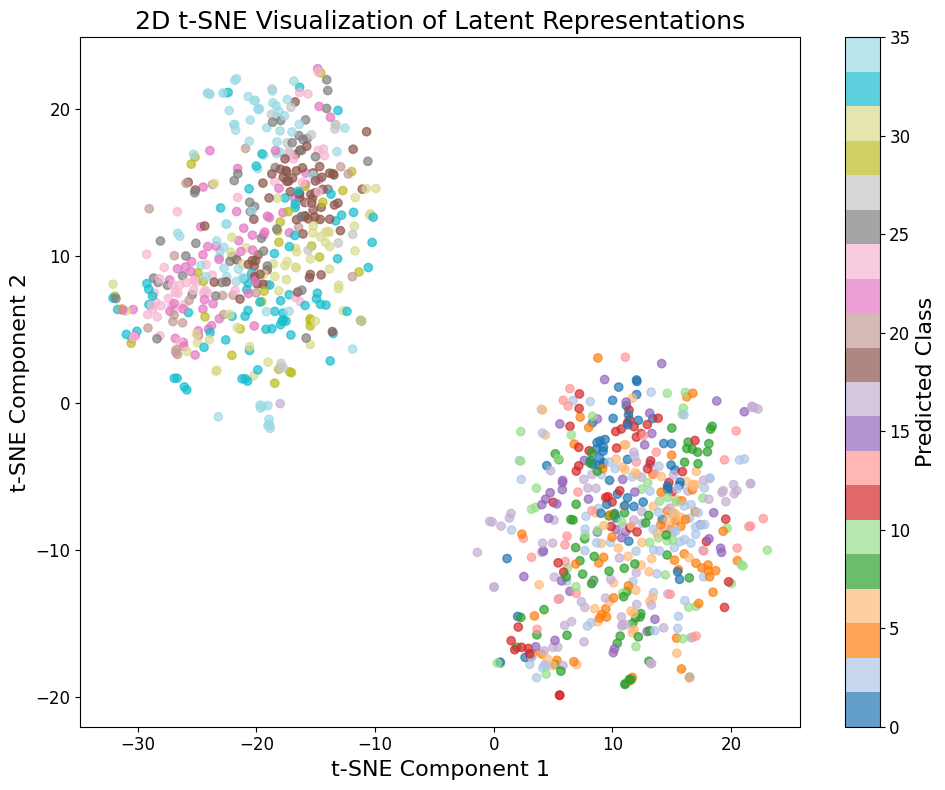

In [103]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_samples = 1000
device = next(inn.parameters()).device
inn.eval()

Xs = []
Zs = []
Cs = []

count = 0
for x_batch, _ in train_loader:
    x_batch = x_batch.to(device)
    with torch.no_grad():
        z, _ = inn(x_batch)
    
    dist = cluster_distances(z, gmm.mu)
    log_probs = -0.5 * dist
    preds = log_probs.argmax(dim=1)
    
    Xs.append(x_batch.cpu())
    Zs.append(z.cpu())
    Cs.append(preds.cpu())
    
    count += x_batch.size(0)
    if count >= n_samples:
        break

Xs = torch.cat(Xs, dim=0)[:n_samples]
Zs = torch.cat(Zs, dim=0)[:n_samples]
Cs = torch.cat(Cs, dim=0)[:n_samples]

# Optional: reduce dimensions with PCA before t-SNE (improves speed/stability)
pca = PCA(n_components=50, random_state=42)
Z_pca = pca.fit_transform(Zs.numpy())

# Run t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
Z_2d = tsne.fit_transform(Zs.numpy())

# Plot the 2D t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=Cs.numpy(), cmap='tab20', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("2D t-SNE Visualization of Latent Representations")
plt.colorbar(label="Predicted Class")
plt.tight_layout()
plt.show()


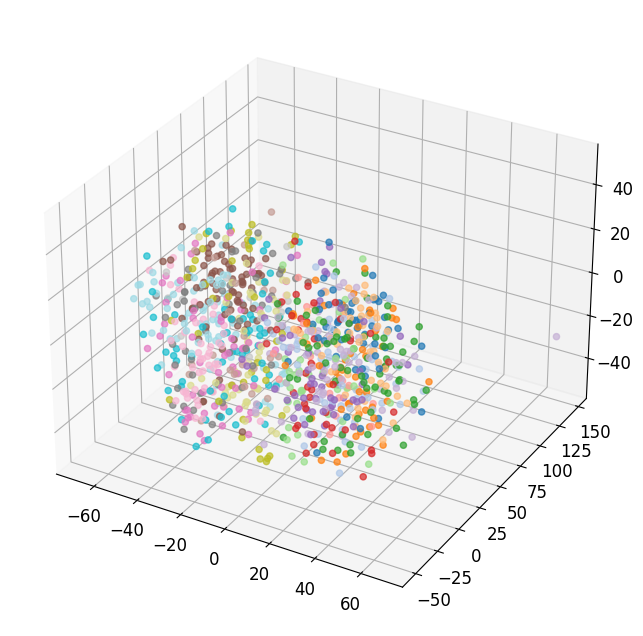

In [102]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_samples=1000
device = next(inn.parameters()).device
inn.eval()


Xs = []
Zs = []
Cs = []


count = 0
for x_batch, _ in train_loader:
    x_batch = x_batch.to(device)
    with torch.no_grad():
        z, _ = inn(x_batch)
    

    dist = cluster_distances(z, gmm.mu)
    log_probs = -0.5 * dist
    preds = log_probs.argmax(dim=1)
    
    Xs.append(x_batch.cpu())
    Zs.append(z.cpu())
    Cs.append(preds.cpu())
    
    count += x_batch.size(0)
    if count >= n_samples:
        break

Xs = torch.cat(Xs, dim=0)[:n_samples]
Zs = torch.cat(Zs, dim=0)[:n_samples]
Cs = torch.cat(Cs, dim=0)[:n_samples]

pca = PCA(n_components=50, random_state=42)
Z_pca = pca.fit_transform(Zs.numpy())


tsne = TSNE(n_components=3, perplexity=20, random_state=42)
Z_3d = tsne.fit_transform(Zs.numpy())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(Z_3d[:, 0], Z_3d[:, 1], Z_3d[:, 2],
                     c=Cs.numpy(), cmap='tab20', alpha=0.7)

plt.show()




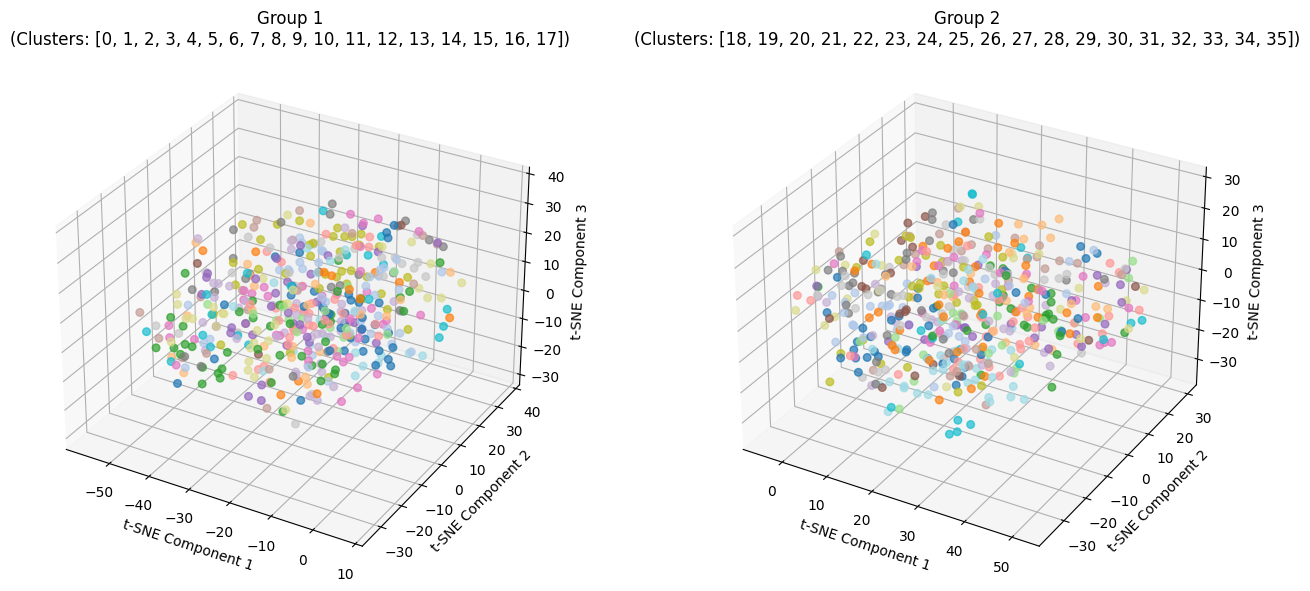

In [124]:
import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting
from scipy.cluster.hierarchy import linkage, fcluster

# -------------------------
# Data Collection & TSNE
# -------------------------
n_samples = 1000
device = next(inn.parameters()).device
inn.eval()

Xs = []
Zs = []
Cs = []  # cluster labels

# Gather up to n_samples from the data_loader
count = 0
for x_batch, _ in val_loader:
    x_batch = x_batch.to(device)
    with torch.no_grad():
        z, _ = inn(x_batch)
    
    # Get cluster assignments
    dist = cluster_distances(z, gmm.mu)
    log_probs = -0.5 * dist
    preds = log_probs.argmax(dim=1)
    
    Xs.append(x_batch.cpu())
    Zs.append(z.cpu())
    Cs.append(preds.cpu())
    
    count += x_batch.size(0)
    if count >= n_samples:
        break

Xs = torch.cat(Xs, dim=0)[:n_samples]
Zs = torch.cat(Zs, dim=0)[:n_samples]
Cs = torch.cat(Cs, dim=0)[:n_samples]

# Optionally, use PCA before t-SNE if needed
pca = PCA(n_components=50, random_state=42)
Z_pca = pca.fit_transform(Zs.numpy())

# Run t-SNE on the latent vectors to obtain a 3D embedding
tsne = TSNE(n_components=3, perplexity=20, random_state=42)
Z_3d = tsne.fit_transform(Zs.numpy())

# -------------------------
# Grouping Clusters
# -------------------------
# Convert cluster assignments to a NumPy array
Cs_np = Cs.numpy()  # shape: (n_samples,)

# Compute the 3D centroid for each unique cluster (assumed clusters 0..35)
unique_clusters = np.unique(Cs_np)
cluster_means = []
for k in unique_clusters:
    points_k = Z_3d[Cs_np == k]  # select points belonging to cluster k
    mean_k = points_k.mean(axis=0)
    cluster_means.append(mean_k)
cluster_means = np.vstack(cluster_means)  # shape: (num_clusters, 3)

# Perform hierarchical clustering (Ward's method) on the cluster centroids
Z_linkage = linkage(cluster_means, method='ward')

# Decide how many groups you want; here we use 2 groups.
num_groups = 2
group_labels = fcluster(Z_linkage, t=num_groups, criterion='maxclust')
# group_labels is an array of length (num_clusters,)
# Each entry corresponds to the group of the cluster with the same index

# -------------------------
# Plotting: Split into Two Subplots
# -------------------------
fig = plt.figure(figsize=(14, 6))

for g in range(1, num_groups + 1):
    ax = fig.add_subplot(1, num_groups, g, projection='3d')
    
    # Identify which clusters belong to group g
    clusters_in_group = [k for k in unique_clusters if group_labels[k] == g]
    
    # Create a mask for points belonging to these clusters
    mask = np.isin(Cs_np, clusters_in_group)
    
    scatter = ax.scatter(
        Z_3d[mask, 0],
        Z_3d[mask, 1],
        Z_3d[mask, 2],
        c=Cs_np[mask],        # color by the original cluster ID
        cmap='tab20',
        alpha=0.7,
        s=30
    )
    
    ax.set_title(f'Group {g}\n(Clusters: {clusters_in_group})')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')

plt.tight_layout()
plt.show()


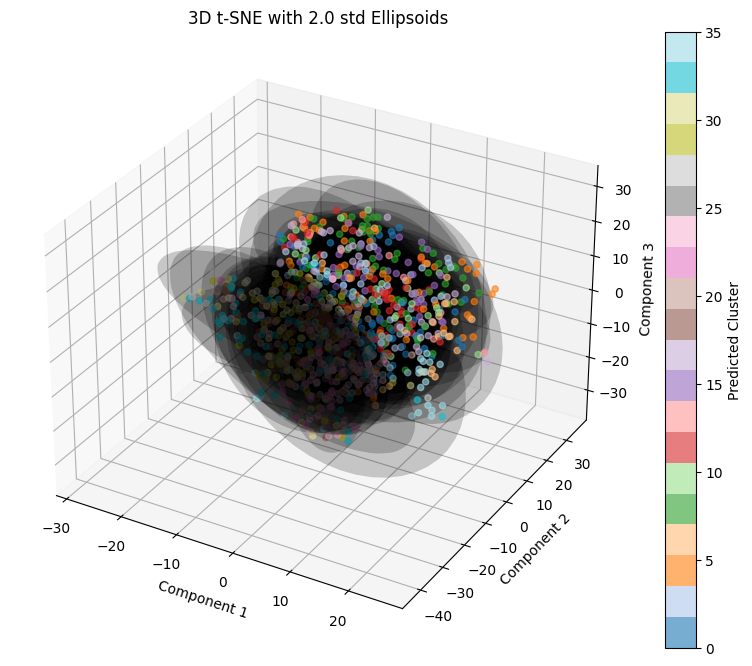

In [115]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # ensures 3D projection is registered

# Suppose Z_3d is your 3D t-SNE output of shape (n_samples, 3)
# and Cs is your cluster assignment (length n_samples)
# We'll write a helper function to plot a 3D ellipsoid

def plot_ellipsoid_3d(ax, mean, cov, n_std=2.0, color='red', alpha=0.2):
    """
    Plot a 3D ellipsoid representing the n_std Gaussian contour
    given a 3D mean and 3x3 covariance matrix.
    """
    # Eigen-decompose the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Sort eigenvalues (and vectors) from largest to smallest
    order = np.argsort(eigenvalues)[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    # Radii for the ellipsoid (the std in each principal direction)
    radii = n_std * np.sqrt(eigenvalues)
    
    # Generate data for a unit sphere
    n_points = 50
    phi = np.linspace(0, np.pi, n_points)
    theta = np.linspace(0, 2*np.pi, n_points)
    phi, theta = np.meshgrid(phi, theta)
    
    # Parametric equations for the sphere
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    
    # Combine into a single matrix (3 x n_points*n_points)
    # shape -> (3, n_points^2)
    xyz = np.vstack([x.flatten(), y.flatten(), z.flatten()])
    
    # Scale by the ellipsoid radii
    # and rotate by the eigenvectors
    # final shape -> (3, n_points^2)
    scaled_rotated_xyz = (eigenvectors @ np.diag(radii) @ xyz).T
    
    # Now translate by the mean
    scaled_rotated_xyz += mean
    
    # Reshape for plotting (n_points, n_points, 3)
    X_ell = scaled_rotated_xyz[:, 0].reshape(n_points, n_points)
    Y_ell = scaled_rotated_xyz[:, 1].reshape(n_points, n_points)
    Z_ell = scaled_rotated_xyz[:, 2].reshape(n_points, n_points)
    
    # Plot the surface
    ax.plot_surface(X_ell, Y_ell, Z_ell, color=color, alpha=alpha, linewidth=0)

# Example usage:
def plot_3d_tsne_with_ellipsoids(Z_3d, Cs, n_clusters=36, n_std=2.0):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter all points
    scatter = ax.scatter(Z_3d[:, 0], Z_3d[:, 1], Z_3d[:, 2],
                         c=Cs, cmap='tab20', alpha=0.6, s=20)
    
    # For each cluster, compute mean & covariance in 3D
    unique_clusters = np.unique(Cs)
    for k in unique_clusters:
        idx = np.where(Cs == k)[0]
        points_k = Z_3d[idx, :]  # shape (num_points_in_k, 3)
        
        if len(points_k) < 2:
            # Not enough points to compute a covariance
            continue
        
        mean_k = points_k.mean(axis=0)
        cov_k = np.cov(points_k.T)  # shape (3, 3)
        
        # Plot the 3D ellipsoid
        # You can choose color or alpha as you like
        plot_ellipsoid_3d(ax, mean_k, cov_k, n_std=n_std,
                          color='black', alpha=0.1)
    
    ax.set_title(f'3D t-SNE with {n_std} std Ellipsoids')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    fig.colorbar(scatter, ax=ax, label='Predicted Cluster')
    plt.show()

# Then just call the function:
plot_3d_tsne_with_ellipsoids(Z_3d, Cs.numpy(), n_clusters=36, n_std=2.0)


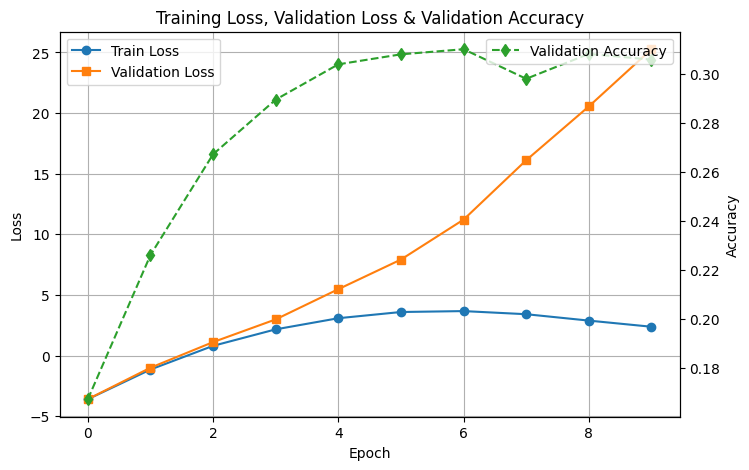

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Create fig
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(train_losses, label="Train Loss", marker='o', color='tab:blue')
ax1.plot(val_losses, label="Validation Loss", marker='s', color='tab:orange')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss, Validation Loss & Validation Accuracy")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(val_accs, label="Validation Accuracy", marker='d', color='tab:green', linestyle='dashed')
ax2.set_ylabel("Accuracy")
ax2.legend(loc="upper right")

plt.show()
plt.savefig("output/inn_training_plot.png")


In [ ]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
z = torch.randn(BATCHSIZE, N_DIM)
samples, _ = inn(z,1, rev=True)
samples = samples.detach().numpy()

In [ ]:
with h5py.File("tactmat.h5", 'r') as dataset:
    raw_samples = dataset['samples'][:] / 154.  # Normalize
    materials = [i.decode() for i in dataset['materials'][:]]  # Decode material names
    
    samples_2 = raw_samples[2, :, :, :, :].reshape(1, 100, 16, 1000)

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


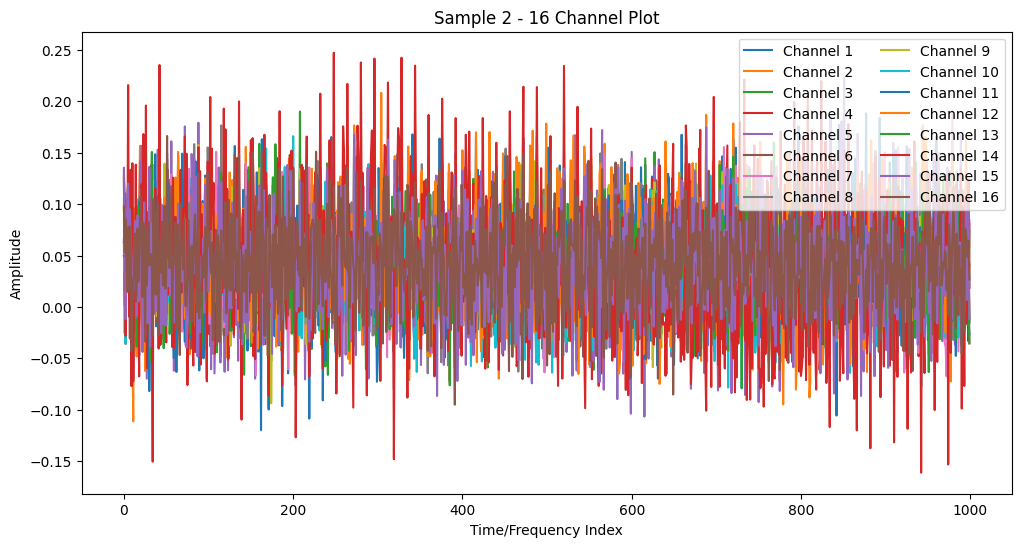

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for i in range(16):
    fft_transformed = samples[i, :1000] + 1j * samples[i, 1000:]

    # Compute the inverse FFT
    ifft_transformed = np.fft.ifft(fft_transformed)

    # If the original signal was real-valued, extract the real part
    recovered_signal = np.real(ifft_transformed)
    
    plt.plot(recovered_signal, label=f'Channel {i+1}')

plt.title(f'Sample 2 - 16 Channel Plot')
plt.xlabel('Time/Frequency Index')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', ncol=2)  # Adjust legend position
plt.show()


In [ ]:
from sklearn.datasets import make_moons

data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)

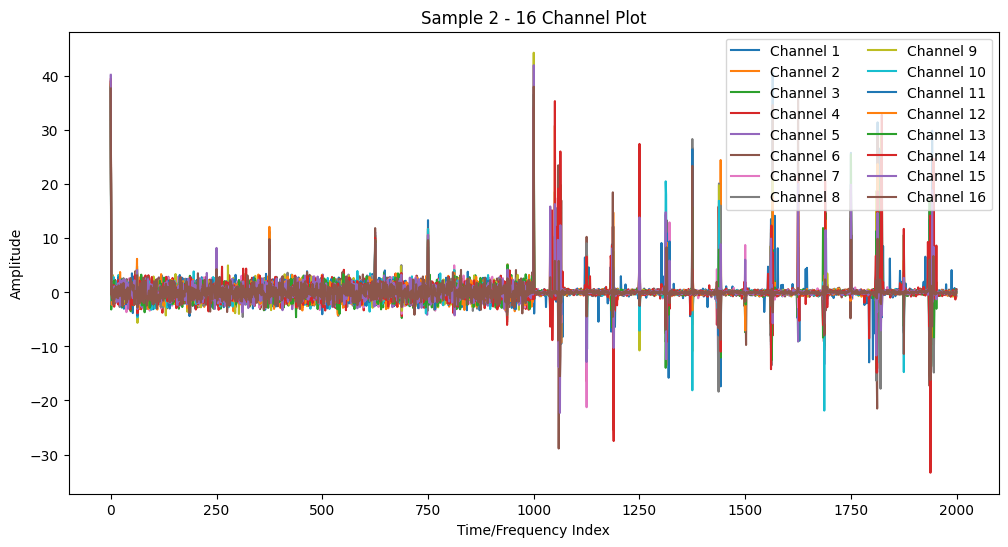

In [ ]:

for i in range(16):
    plt.plot(samples[i, :], label=f'Channel {i+1}')

plt.title(f'Sample 2 - 16 Channel Plot')
plt.xlabel('Time/Frequency Index')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', ncol=2)  # Adjust legend position
plt.show()